In [1]:
%load_ext autoreload
%autoreload 2

In [177]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix

from sklearn.compose import make_column_transformer

from sklearn.impute import KNNImputer
from feature_engine import imputation
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser, DecisionTreeDiscretiser
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine import transformation as vt
from feature_engine.creation import CyclicalTransformer, MathematicalCombination, CombineWithReferenceFeature
from feature_engine.selection import RecursiveFeatureElimination, DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures, SelectByShuffling

import lightgbm as lgb


import optuna
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src.pipe_func import *
from src.eda_functions import *

import warnings
warnings.filterwarnings("ignore")



## Load data and split train and test

In [3]:
# load dataset
song_df = pd.read_csv("../../data/train.csv").set_index('id')
test = pd.read_csv("../../data/test.csv").set_index('id')
song_df.head()


,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
id,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
# convert column to categorical
cat_vars = ['key','audio_mode','time_signature','song_popularity']
song_df[cat_vars] = song_df[cat_vars].astype("object")
test[['key','audio_mode','time_signature']] = test[['key','audio_mode','time_signature']].astype("object")


cont_vars = [var for var in song_df.columns if var not in cat_vars]
cat_vars = ['key','audio_mode','time_signature'] # remove target variable

In [5]:
# split independent and dependent variables
y = song_df['song_popularity'].astype('int')
X = song_df[cont_vars + ['key','audio_mode','time_signature']]


## Explonatory data analysis

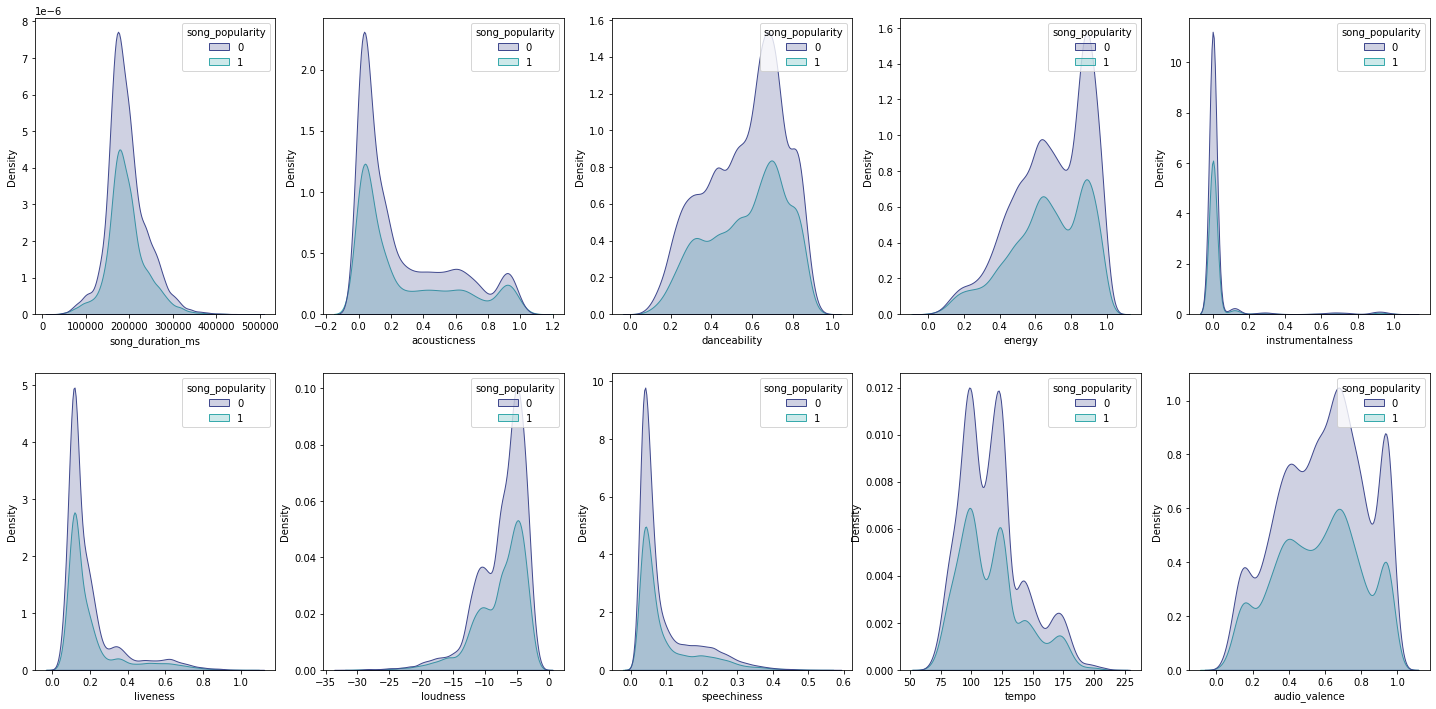

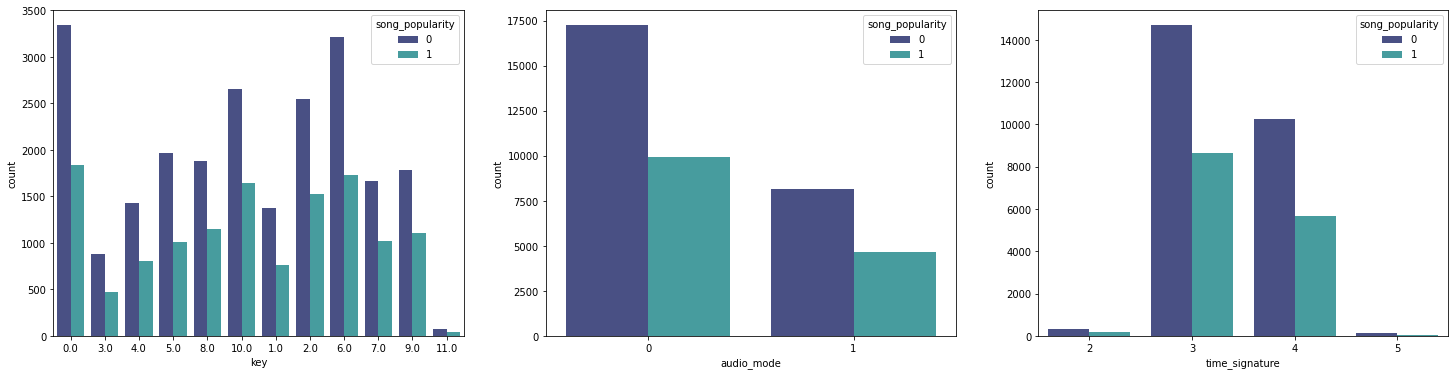

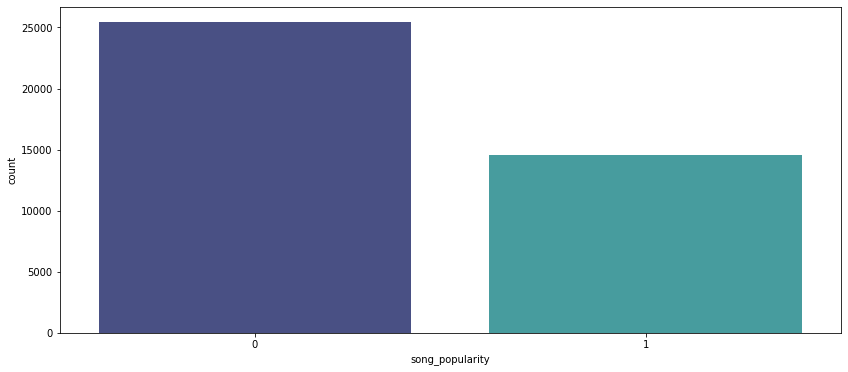

In [48]:
# Distribution analysis
plt.figure(figsize=(25,12))
for i, j in enumerate(cont_vars):
    plt.subplot(2,5,i+1)
    sns.kdeplot(song_df[j], fill = True, hue = song_df['song_popularity'], palette = 'mako')
plt.show()

plt.figure(figsize=(25,6))
for i, j in enumerate(cat_vars ):
    plt.subplot(1,3,i+1)
    sns.countplot(song_df[j], hue = song_df['song_popularity'], palette='mako')
plt.show()

plt.figure(figsize=(14,6))
sns.countplot(song_df['song_popularity'], palette='mako')
plt.show()

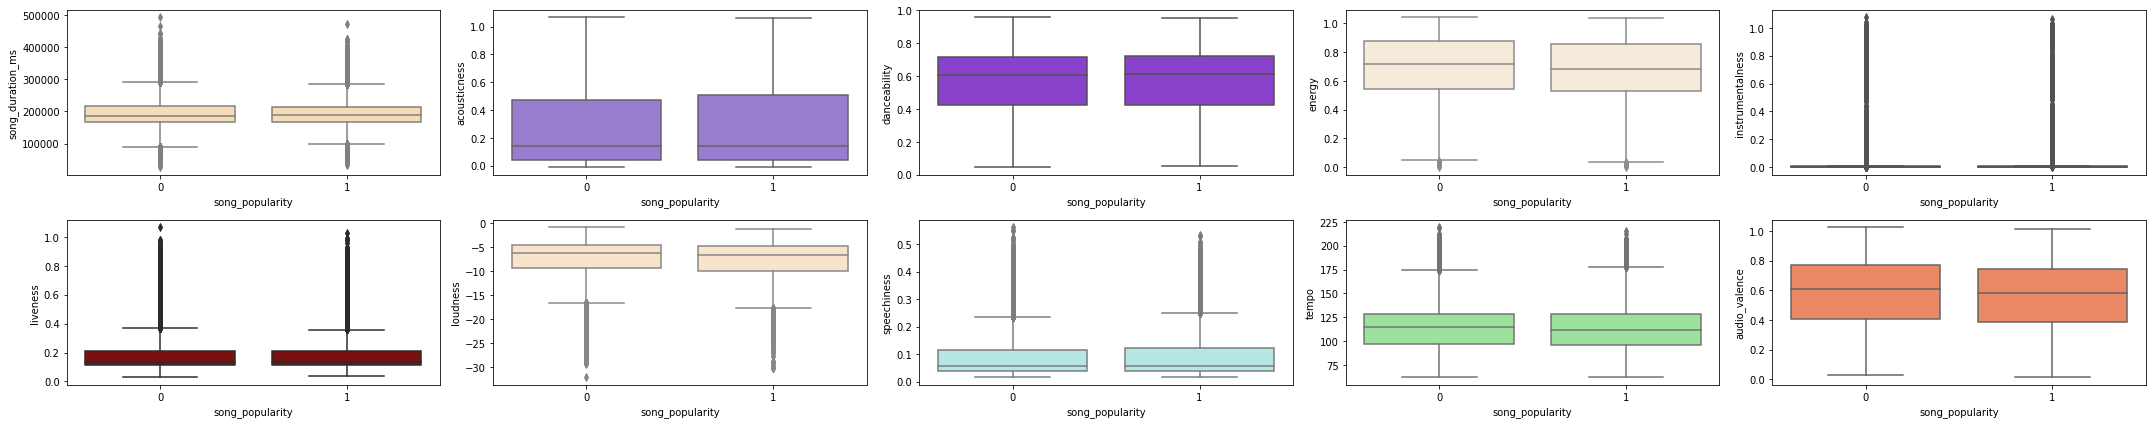

In [49]:
# Outlier analysis & differnt in mean between two classes
import matplotlib.colors as mcolors
import random

plt.figure(figsize=(30,6))
for i, j in enumerate(cont_vars):
    plt.subplot(2,5,i+1)
    sns.boxplot(data = song_df, y = j, x='song_popularity', color = random.choice(list(mcolors.CSS4_COLORS.values())))
plt.tight_layout()
plt.show()

<Figure size 1800x432 with 0 Axes>

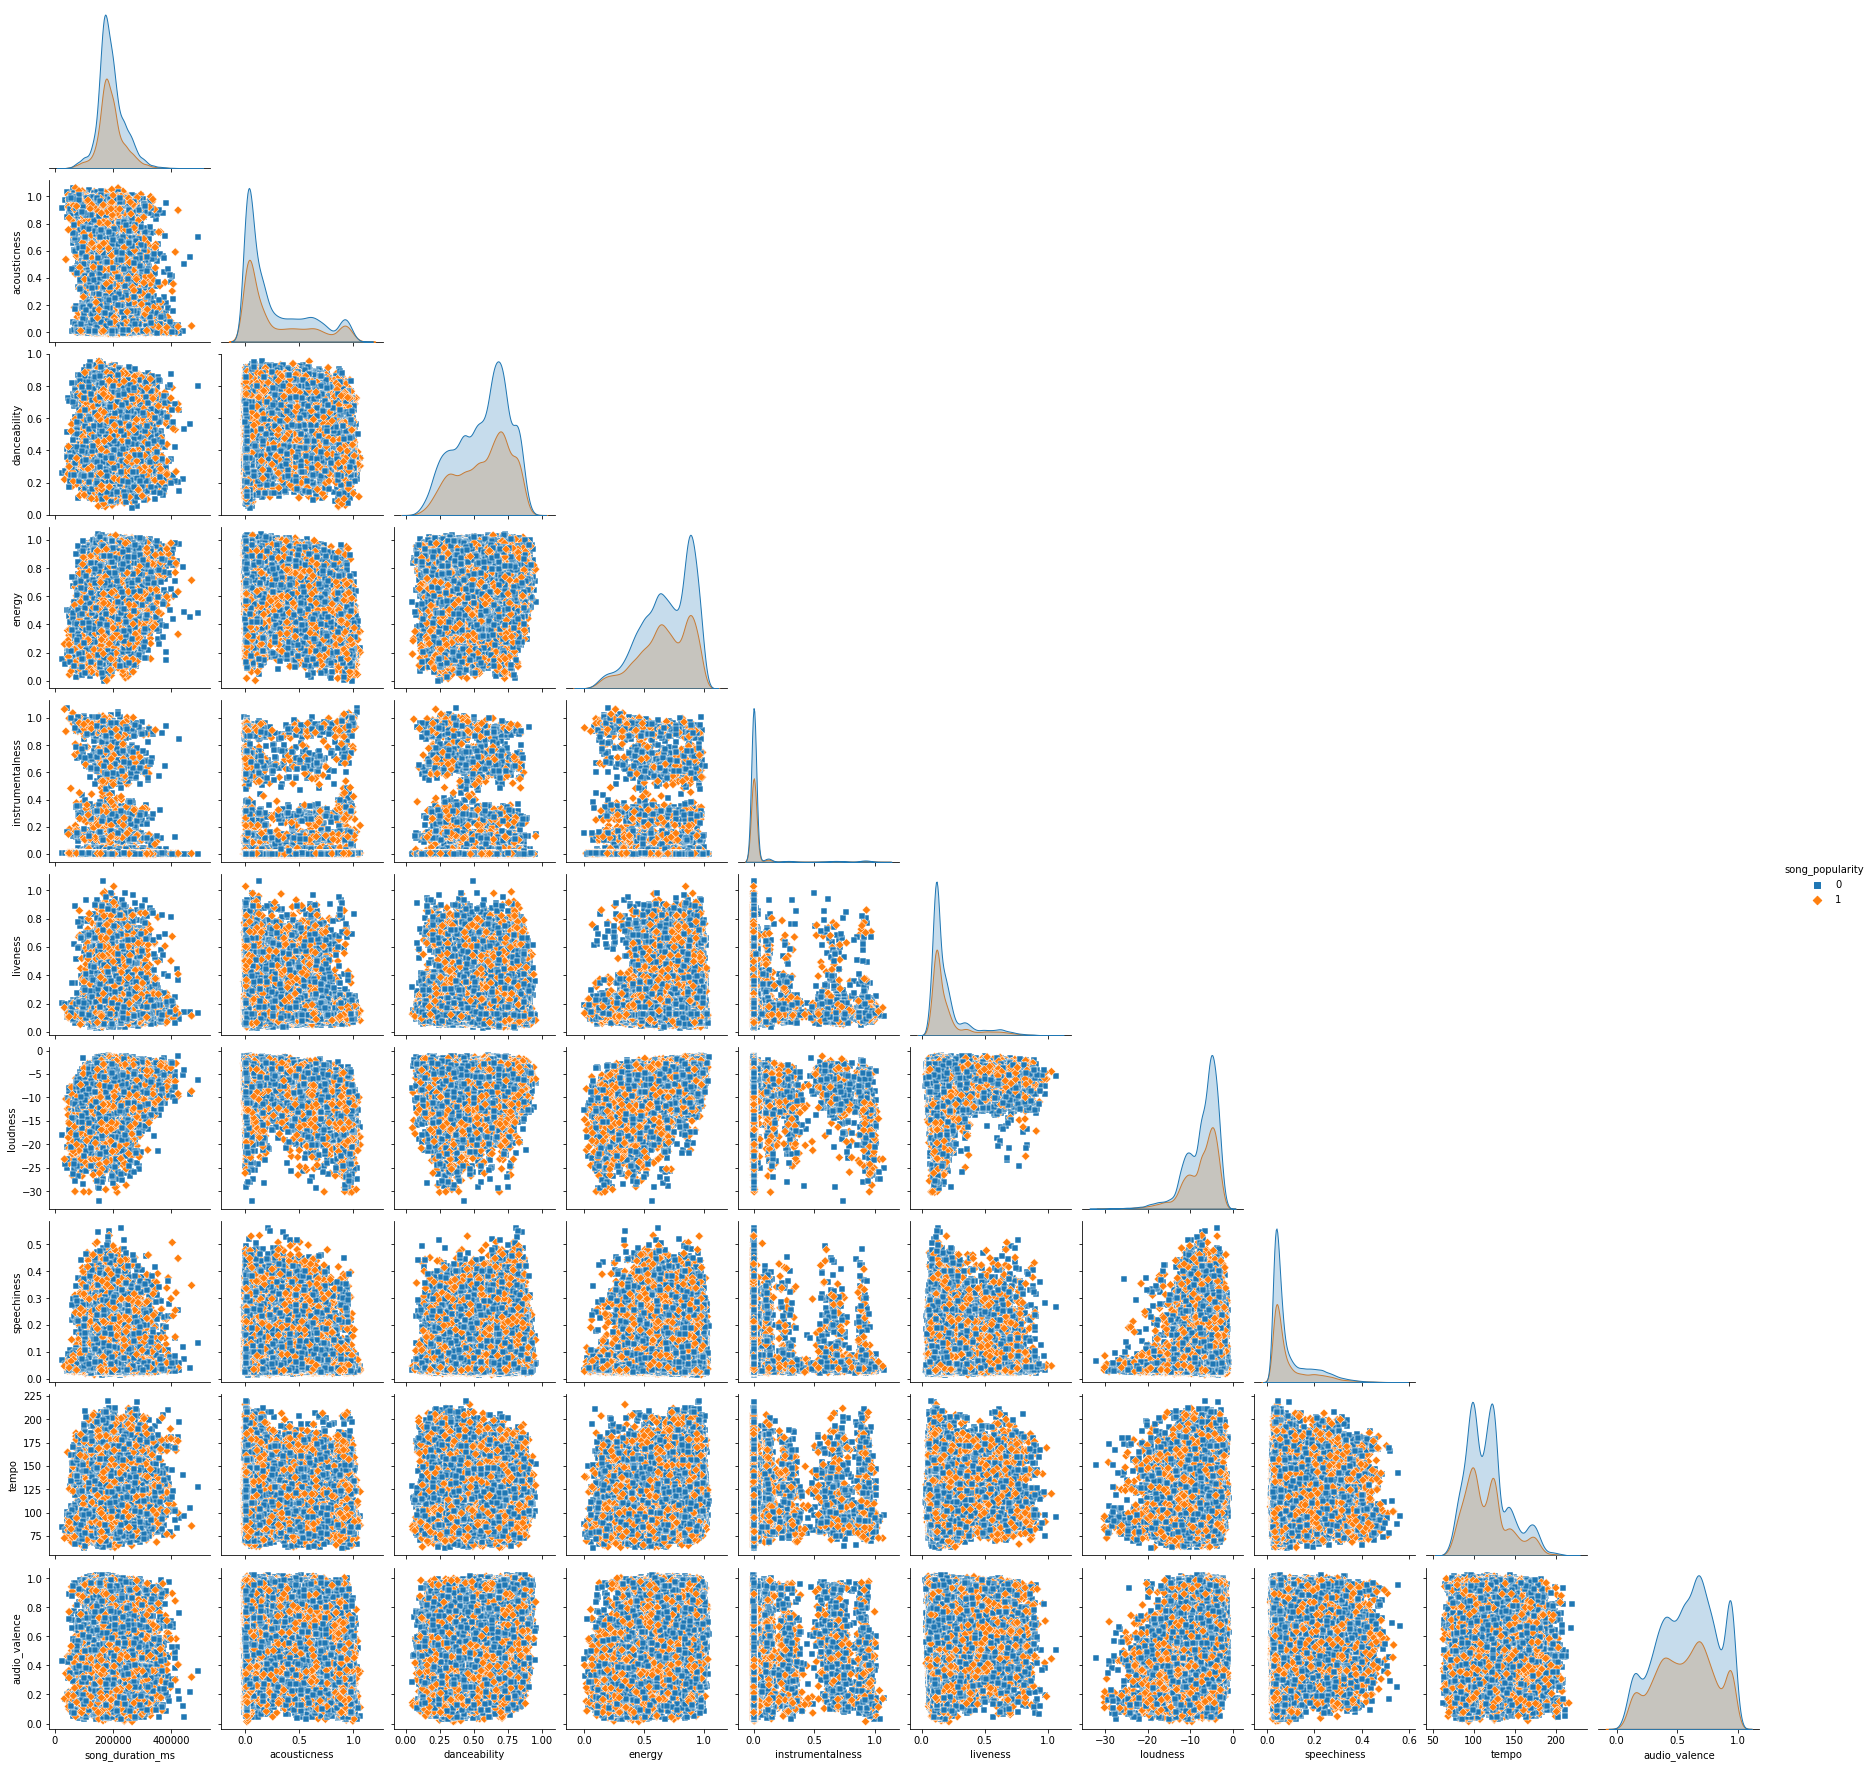

In [ ]:
# scatter plot & correlation plot
plt.figure(figsize=(25,6))
sns.pairplot(data = song_df[cont_vars + ["song_popularity"]], hue ='song_popularity',markers = ['s','D'],corner = True)
plt.show()

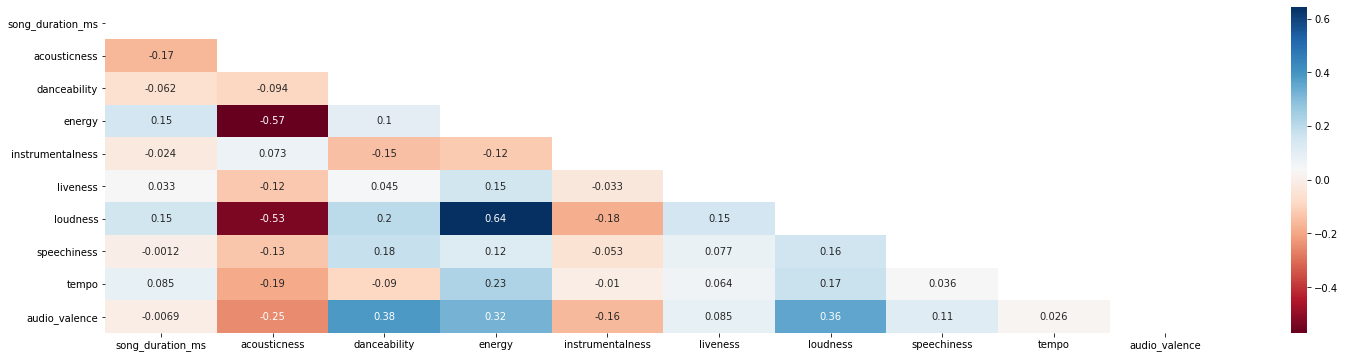

In [ ]:
# correlation plot
plt.figure(figsize=(25,6))
mask = np.triu(np.ones_like(song_df[cont_vars + ["song_popularity"]].corr()))
sns.heatmap(data = song_df[cont_vars + ["song_popularity"]].corr(), cmap ='RdBu', annot=True, mask = mask)
plt.show()

## Missing value analysis

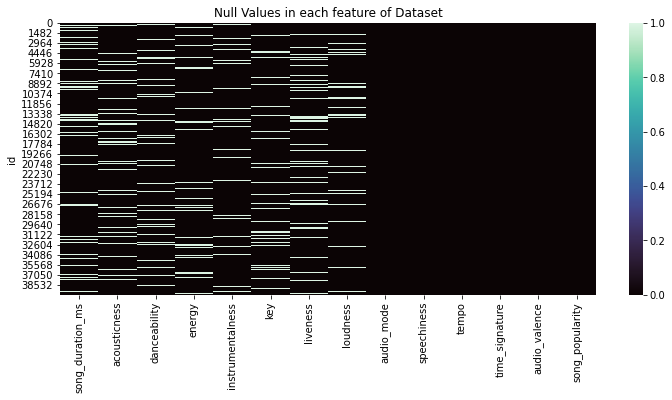

In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(song_df.isnull(), cmap='mako')
plt.title('Null Values in each feature of Dataset')
plt.show()

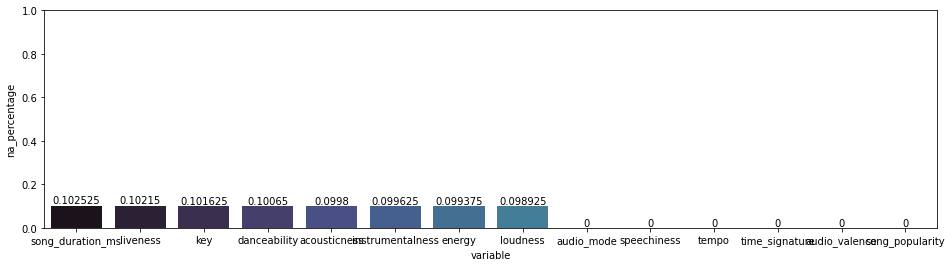

In [ ]:
# Calculate percentage of missingness
# vars_with_na = song_df.loc[:,song_df.isnull().any().values].columns.tolist()
data_na = pd.DataFrame(song_df.isnull().mean().reset_index())
data_na.columns = ['variable','na_percentage']

data_na.sort_values(by = 'na_percentage', ascending=False, inplace=True)
data_na

plt.figure(figsize=(16,4))
ax = sns.barplot(data=data_na, x = 'variable', y = 'na_percentage', palette='mako')
ax.set_ylim([0, 1])
ax.bar_label(ax.containers[0])
plt.show()

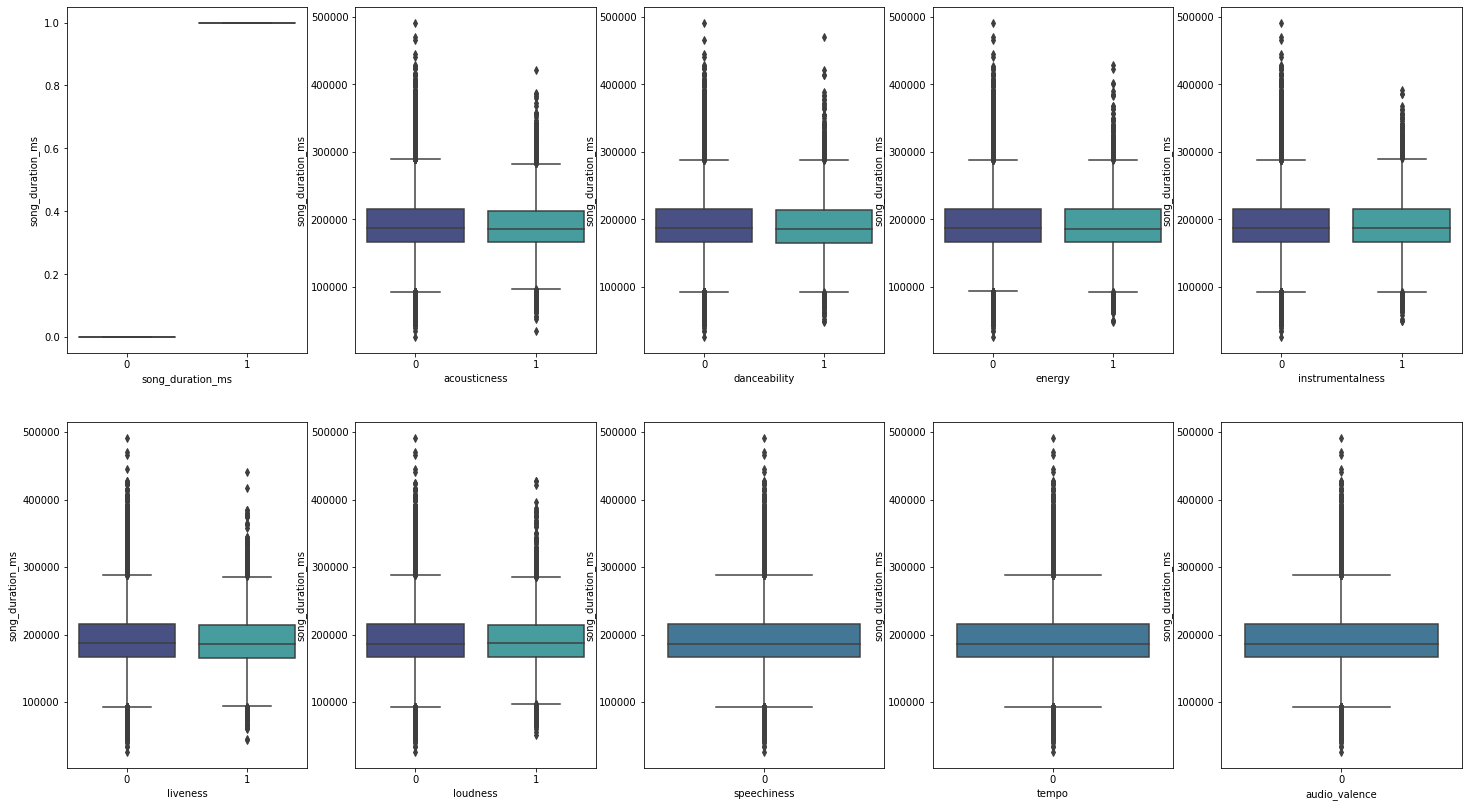

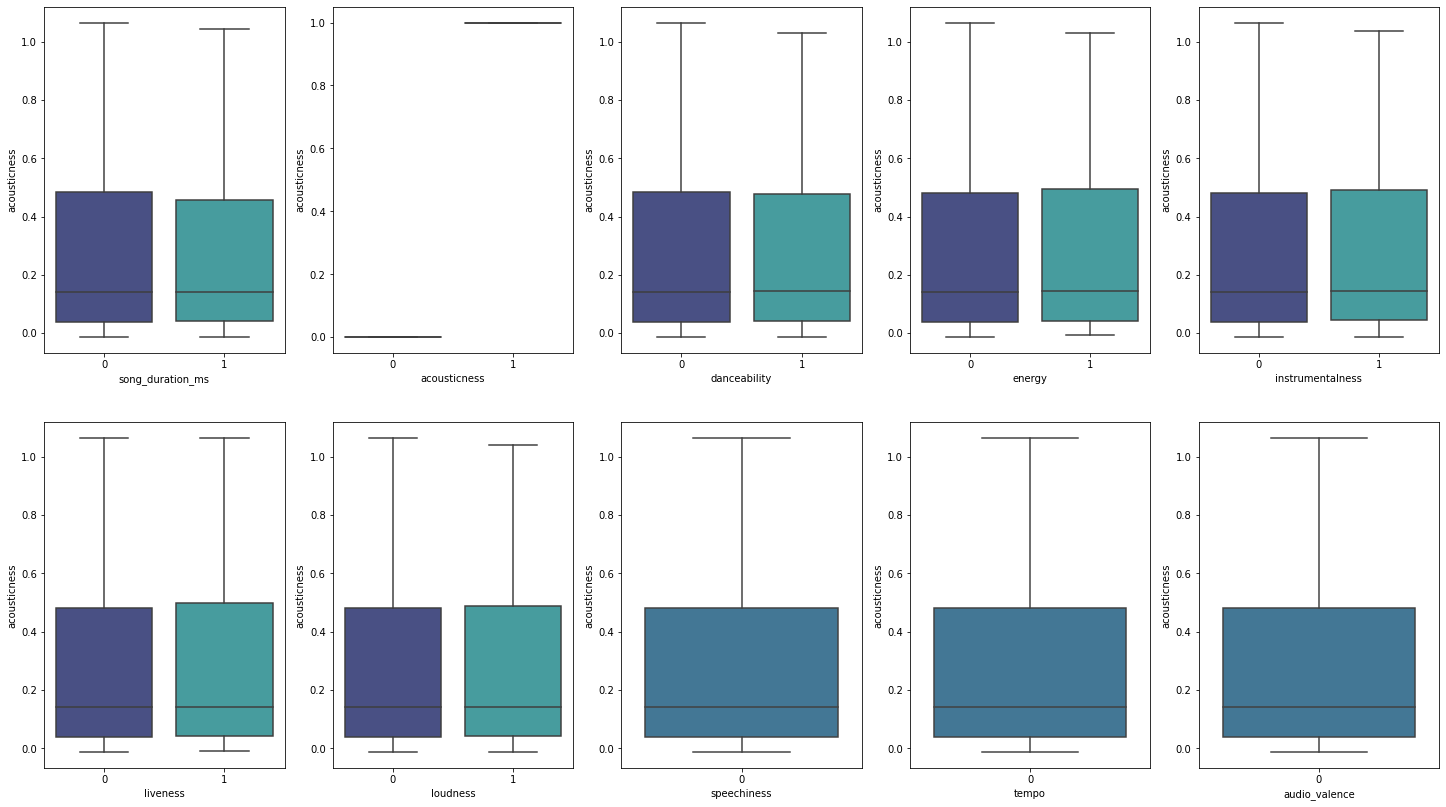

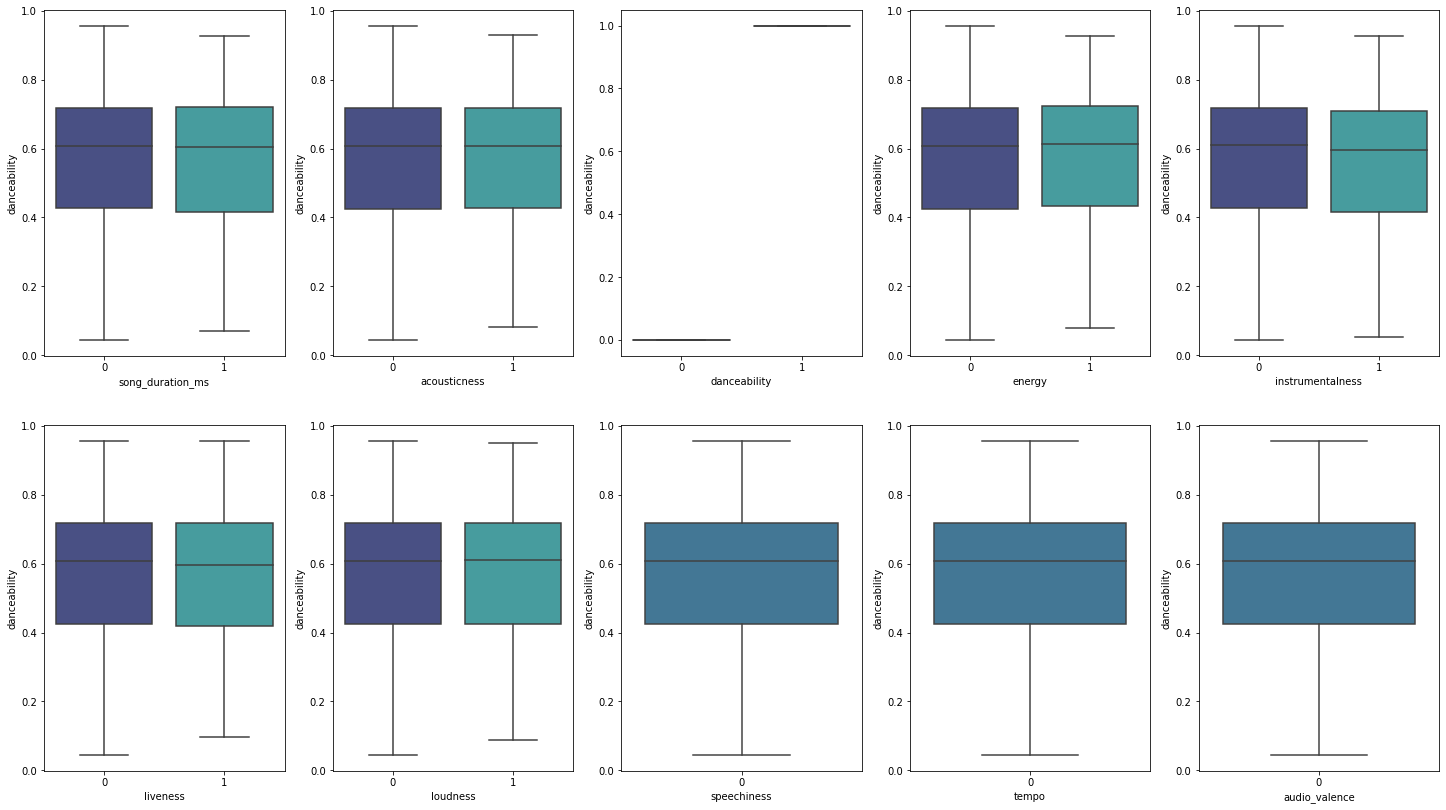

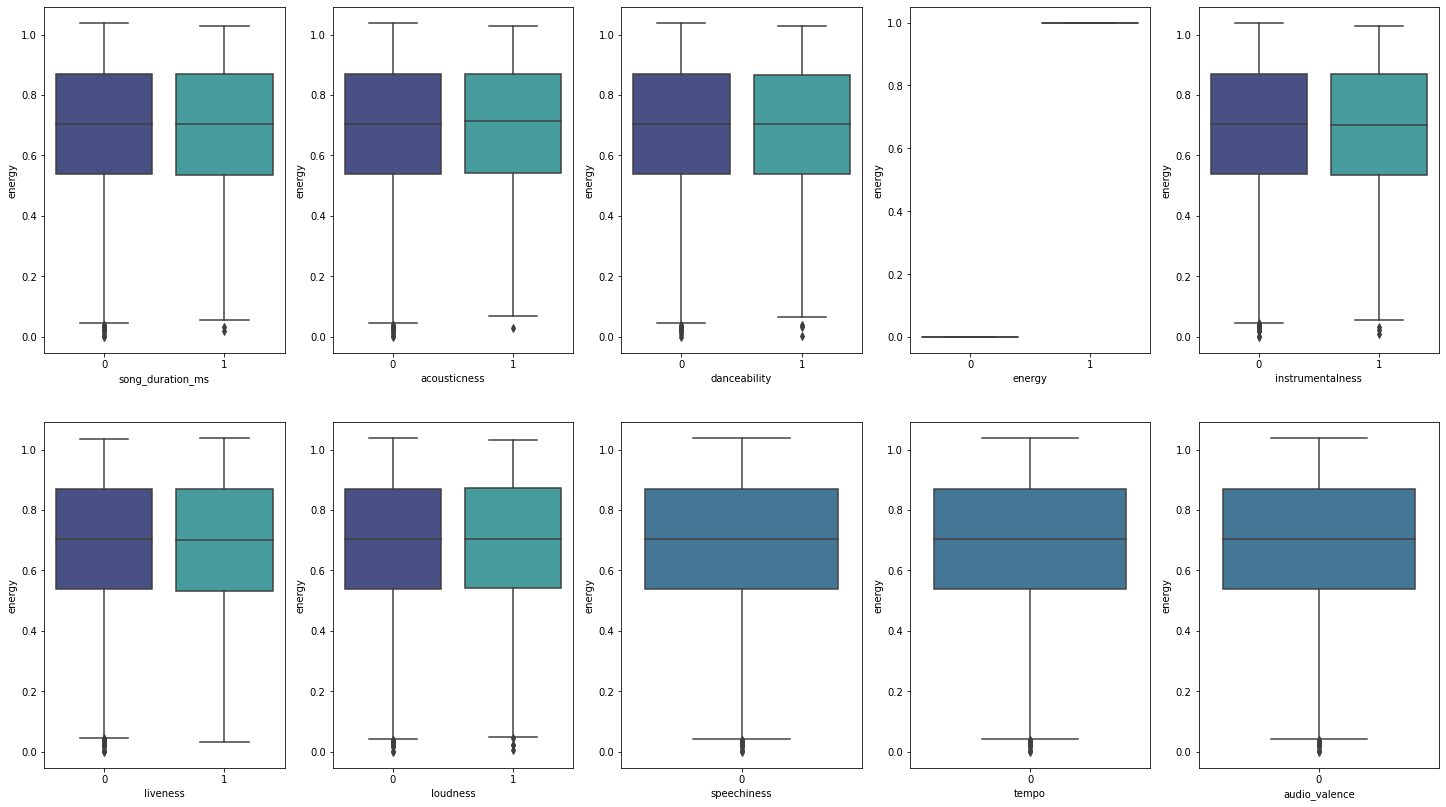

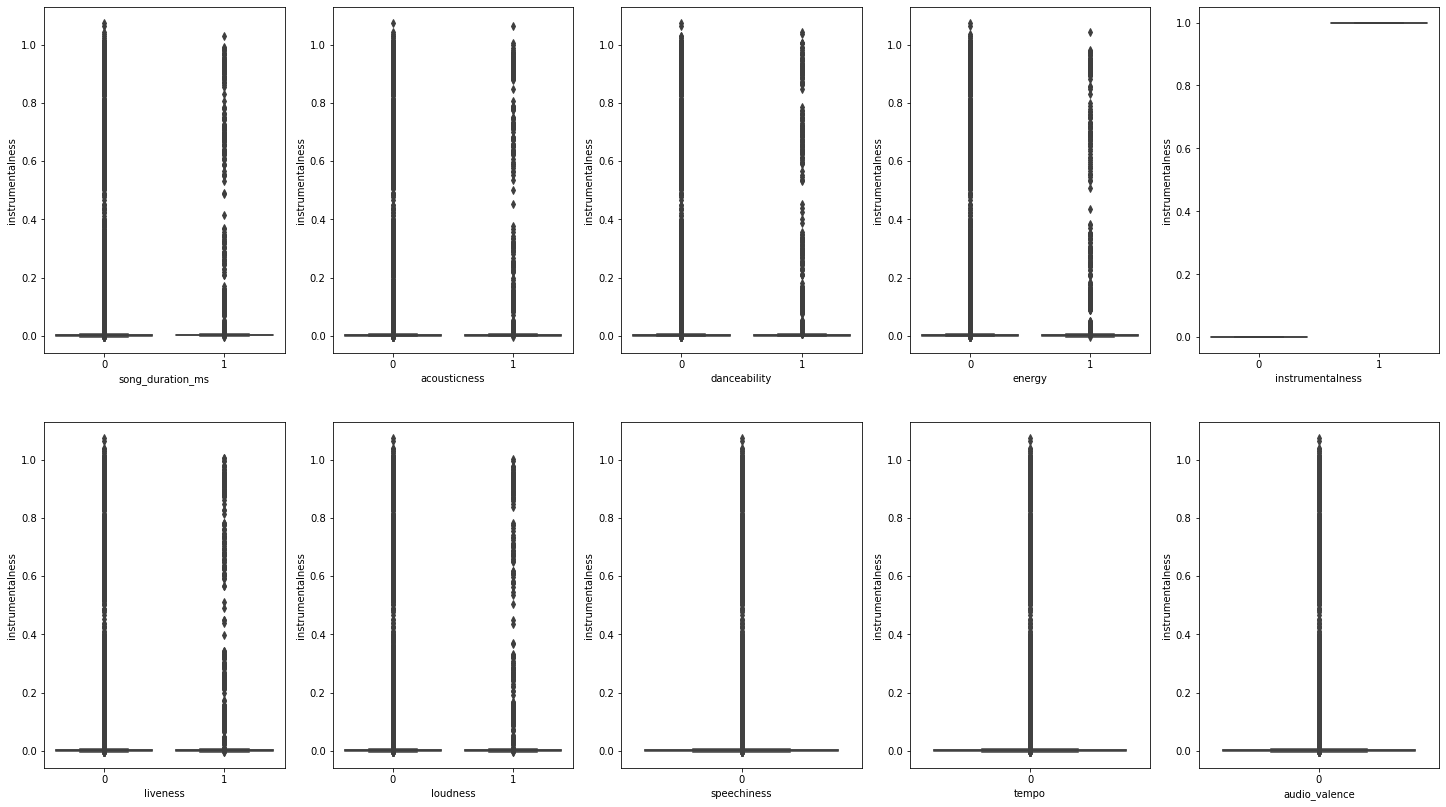

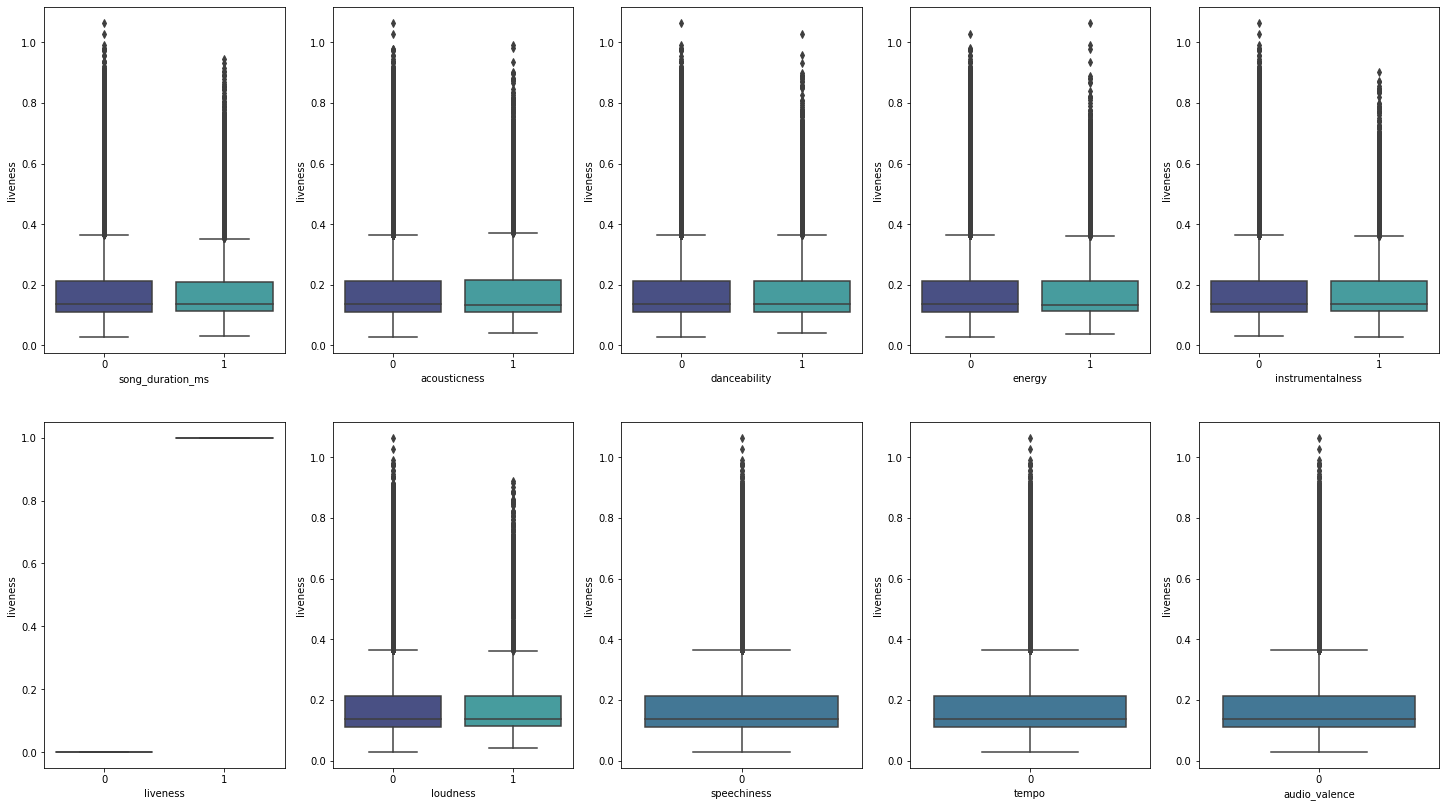

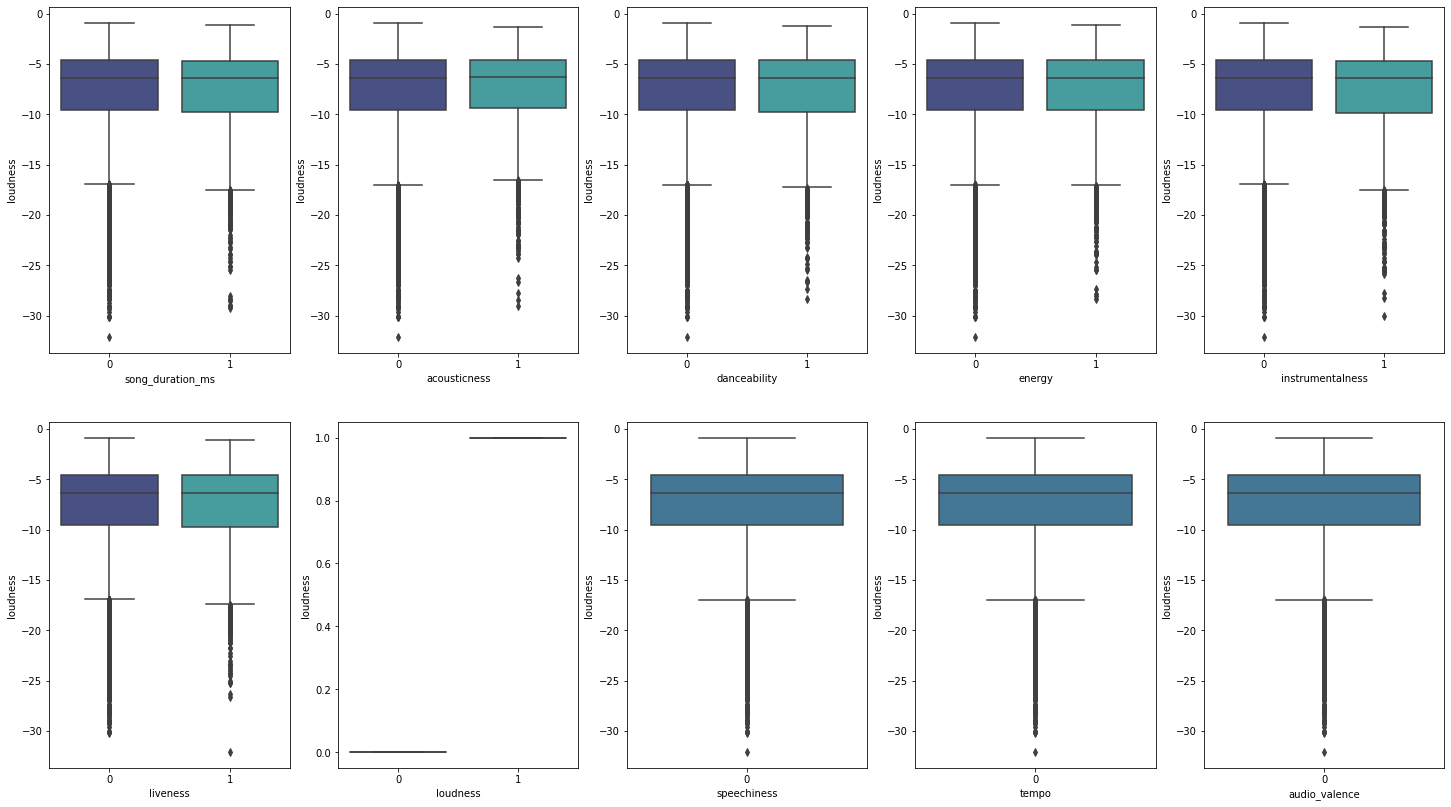

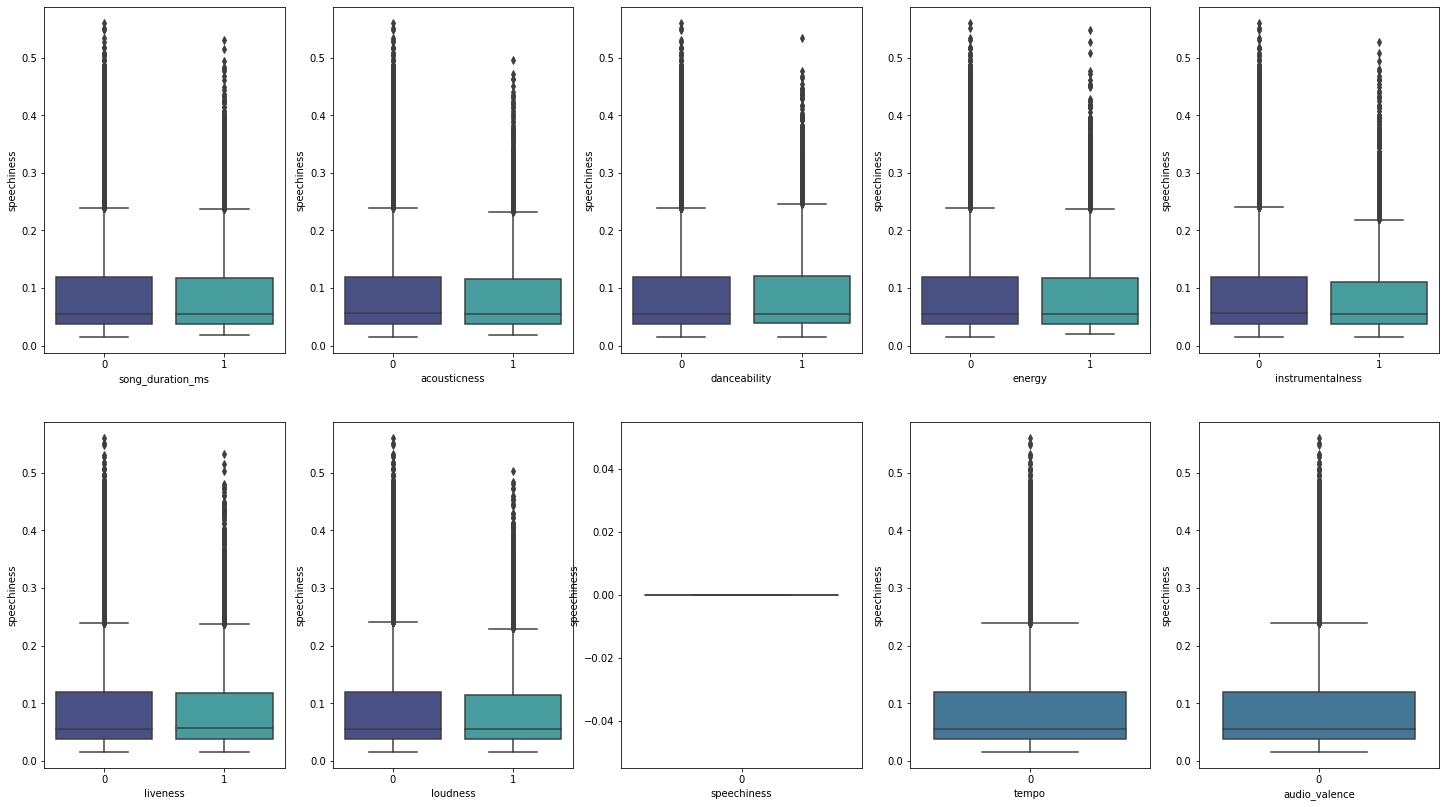

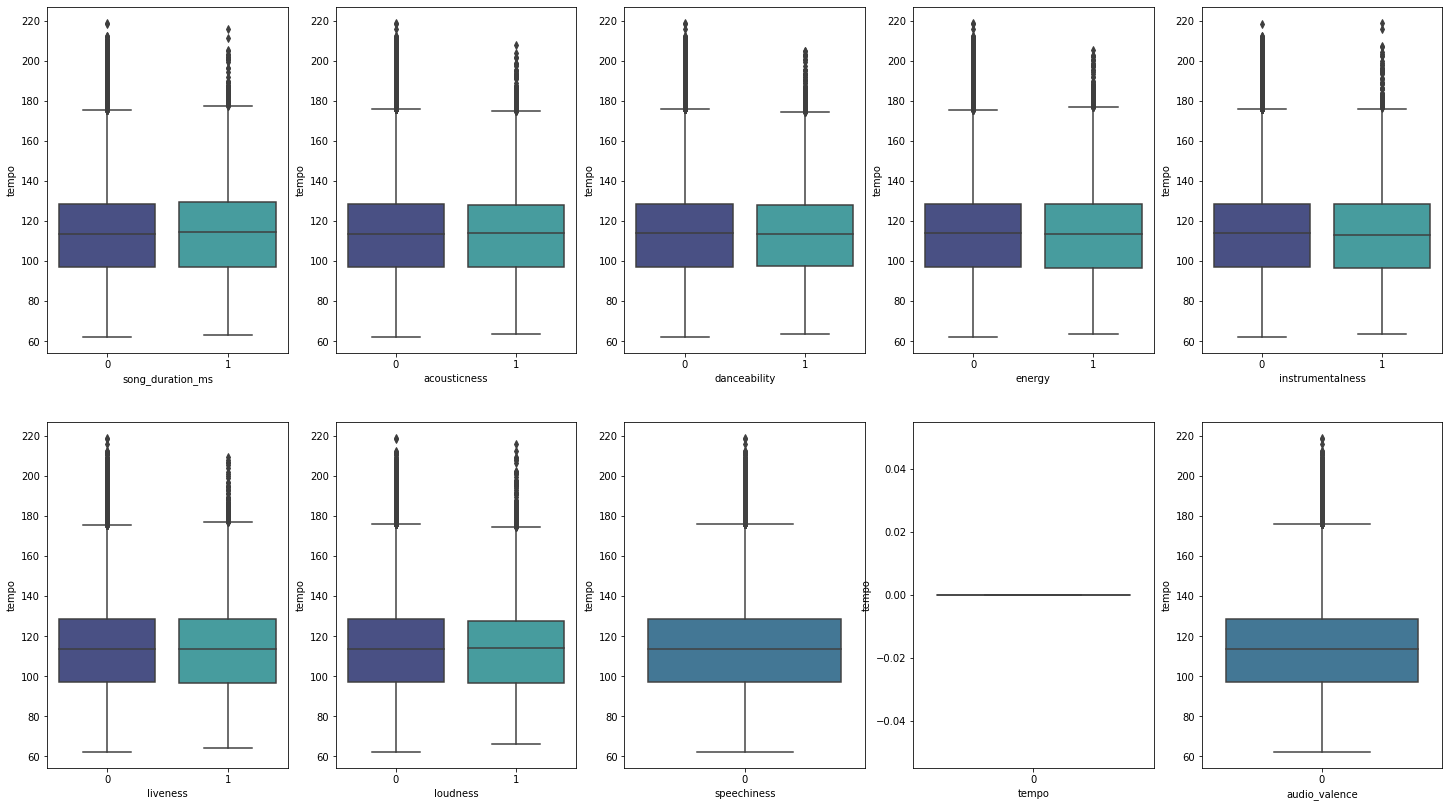

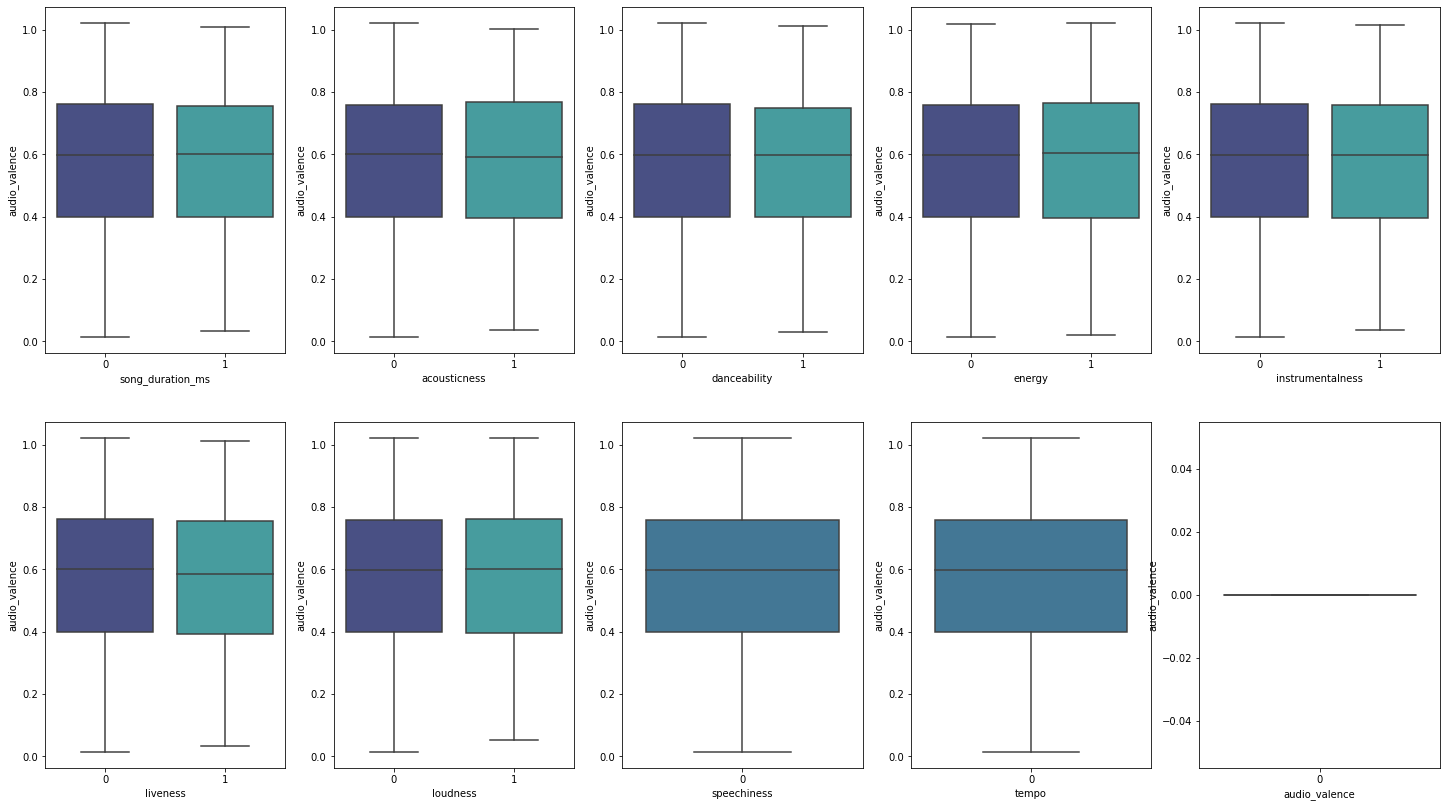

In [ ]:
def analyse_na_value_mcont_rcont(df, missing_var, reference_var):
    temp = df.copy()

    temp[missing_var] = np.where(temp[missing_var].isnull(),1, 0 )

    sns.boxplot(data=temp, x =missing_var, y = reference_var, palette='mako')

for cont_var in cont_vars:
    plt.figure(figsize=(25,14))
    for i, j in enumerate(cont_vars):
        plt.subplot(2,5,i+1)
        analyse_na_value_mcont_rcont(song_df, j, cont_var)
    plt.show()



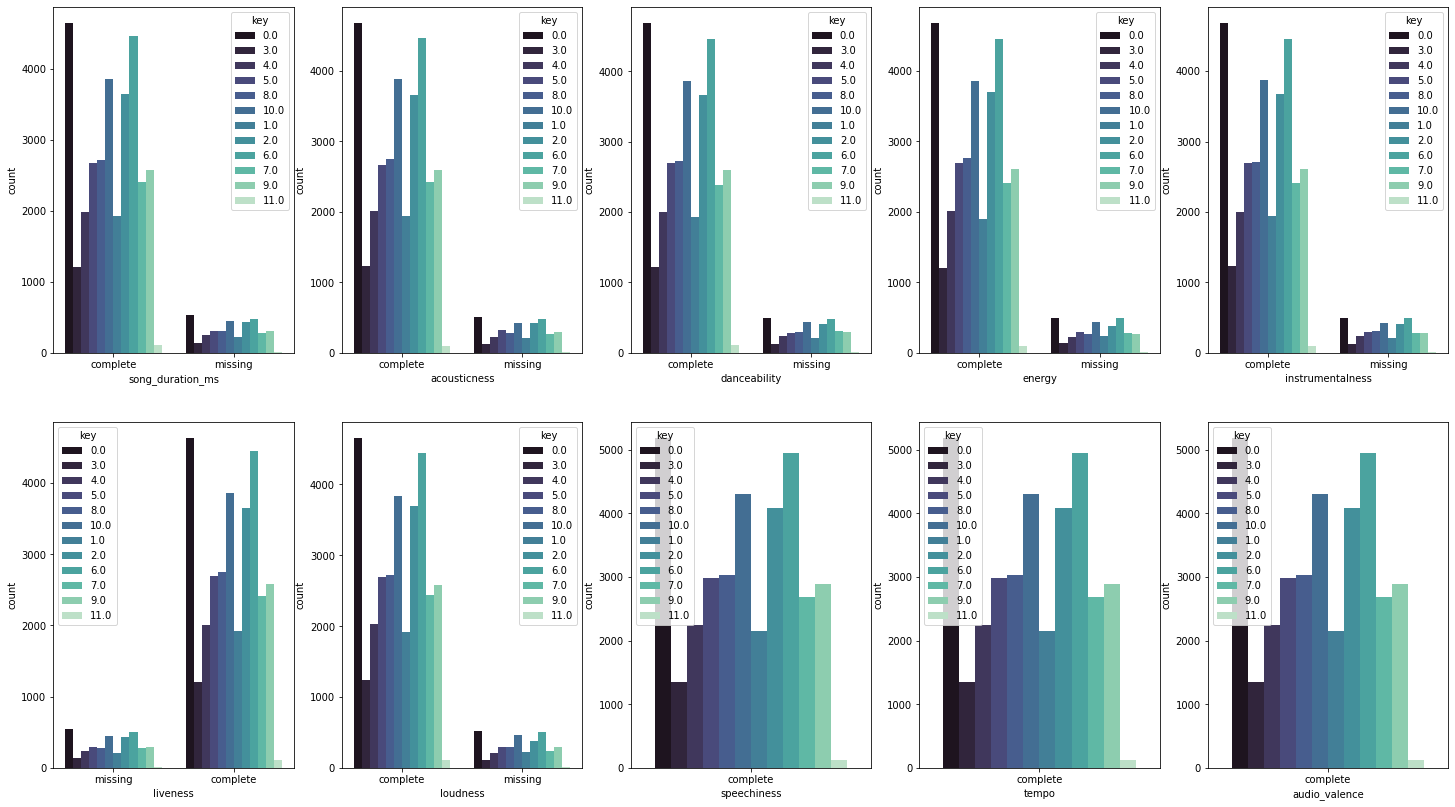

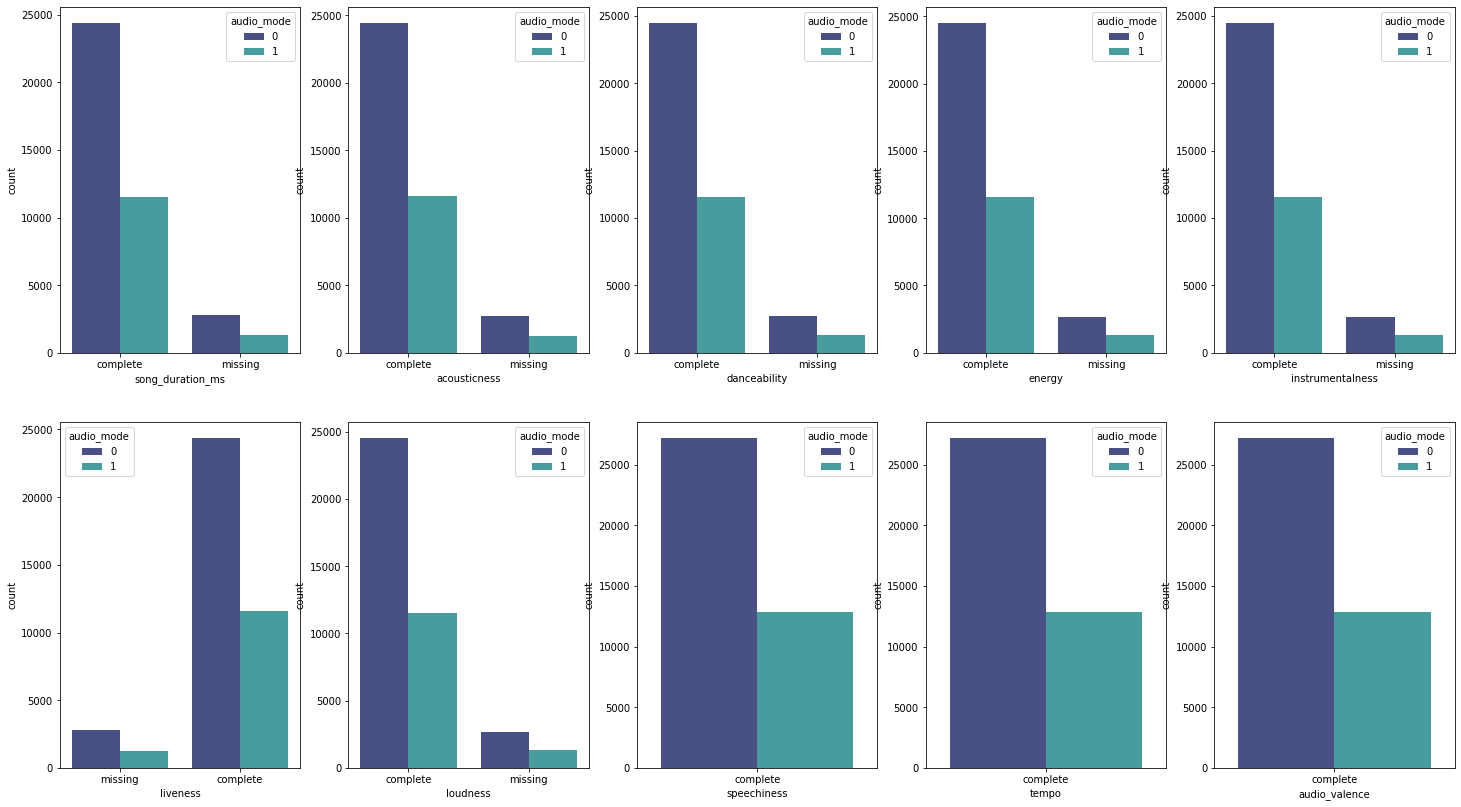

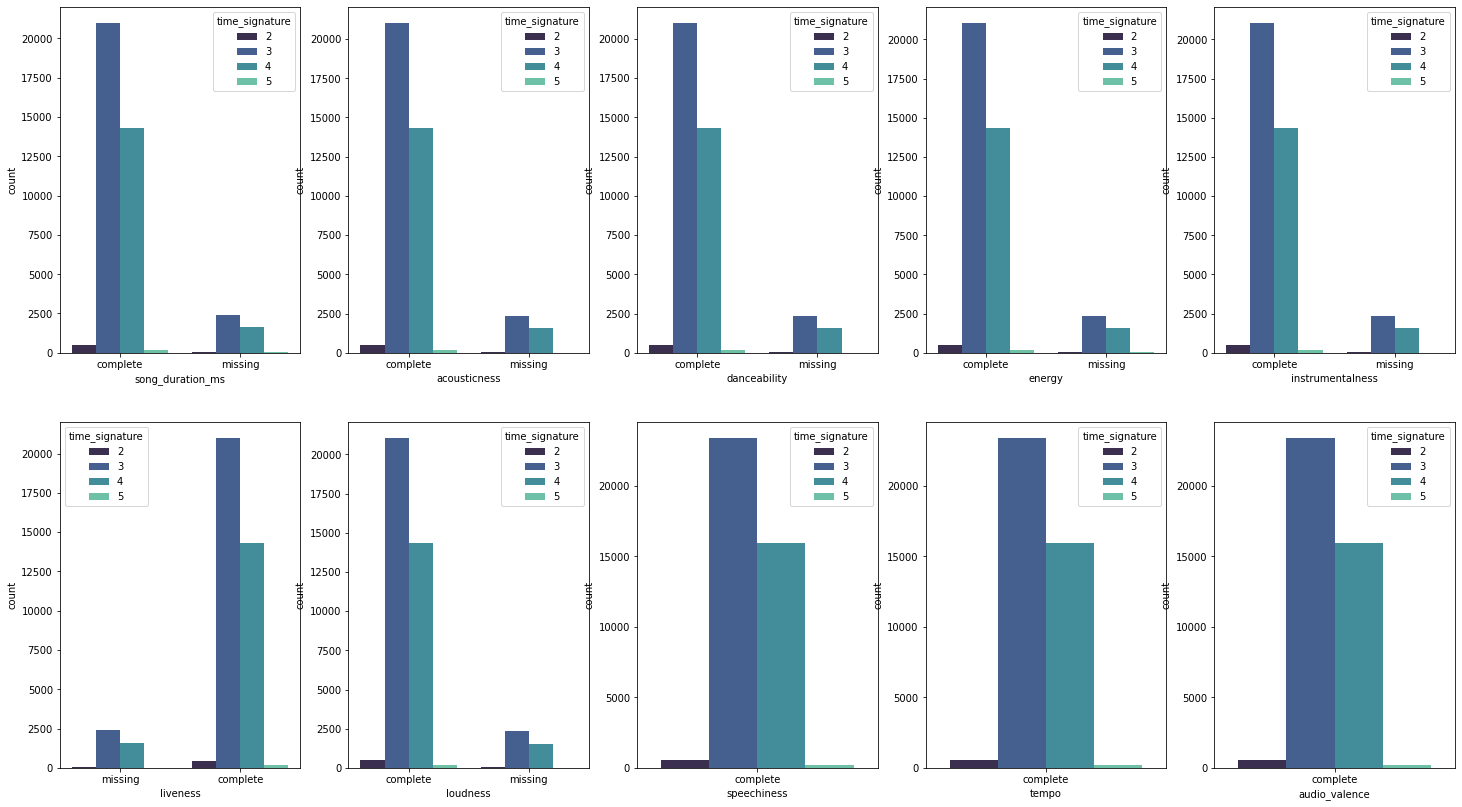

In [ ]:
def analyse_na_value_mcont_rcat(df, missing_var, reference_var):
    temp = df.copy()

    temp[missing_var] = np.where(temp[missing_var].isnull(),"missing", "complete" )

    sns.countplot(data=temp, x =missing_var, hue = reference_var, palette='mako')


for cat_var in cat_vars:
    plt.figure(figsize=(25,14))
    for i, j in enumerate(cont_vars):
        plt.subplot(2,5,i+1)
        analyse_na_value_mcont_rcat(song_df, j, cat_var)
    plt.show()


## Missing imputation

In [6]:
add_miss_imputation = imputation.AddMissingIndicator(missing_only=True)
cont_imputation = imputation.MeanMedianImputer(imputation_method='median', variables=cont_vars)
cat_imputation = imputation.CategoricalImputer( variables= cat_vars)

imputation_pipe = Pipeline(steps=[
    ('add_miss_imputation', add_miss_imputation),
    ('cont_imputation', cont_imputation),
    ('cat_imputation', cat_imputation),
])

In [56]:
imputation_pipe.fit_transform(X)

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,audio_mode,time_signature,song_duration_ms_na,acousticness_na,danceability_na,energy_na,instrumentalness_na,liveness_na,loudness_na,key_na
id,,,,,,,,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,0.135945,-5.619088,0.082570,158.386236,0.734642,...,0,4,0,0,0,0,0,1,0,0
1,186660.0,0.054866,0.733289,0.835545,0.000996,0.436428,-5.236965,0.127358,102.752988,0.711531,...,1,3,1,0,0,0,0,0,0,0
2,193213.0,0.140532,0.188387,0.783524,-0.002694,0.170499,-4.951759,0.052282,178.685791,0.425536,...,0,3,0,1,0,0,0,0,0,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.094805,-7.893694,0.035618,128.715630,0.453597,...,0,3,0,0,0,0,0,0,0,0
4,165969.0,0.493017,0.608234,0.740982,0.002033,0.094891,-2.684095,0.050746,121.928157,0.741311,...,0,4,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,237799.0,0.140532,0.748942,0.511234,0.002913,0.173803,-8.853673,0.078060,168.262924,0.178159,...,0,3,0,1,0,0,0,0,0,0
39996,191119.0,0.067488,0.672830,0.889685,0.001225,0.122924,-7.798993,0.188607,110.684544,0.790626,...,0,3,0,0,0,0,0,0,0,0
39997,160879.0,0.877431,0.409065,0.292671,0.001974,0.110664,-15.378585,0.031294,99.556074,0.177947,...,0,3,0,0,0,0,1,0,0,0


## feature transformation

In [9]:
lt = vt.LogTransformer(['liveness'])
rt = vt.ReciprocalTransformer(['tempo'])
pt = vt.PowerTransformer(['danceability', 'audio_valence' ])
box_t = vt.BoxCoxTransformer(['speechiness'])
yt = vt.YeoJohnsonTransformer(['song_duration_ms', 'loudness'])

ohe = dummify(variables=cat_vars, drop_first=True)

transformation_pipe = Pipeline(steps=[
    ('LogTransformer', lt),
    ('ReciprocalTransformer', rt),
    ('PowerTransformer', pt),
    ('BoxCoxTransformer', box_t),
    ('YeoJohnsonTransformer', yt),
    ('dummify', ohe),
])

twostep_pipe = Pipeline([
    ('imputation_pipe',imputation_pipe),
    ('transformation_pipe',transformation_pipe)
])

X_2step = twostep_pipe.fit_transform(X)

## feature engineering 1 - kmeans

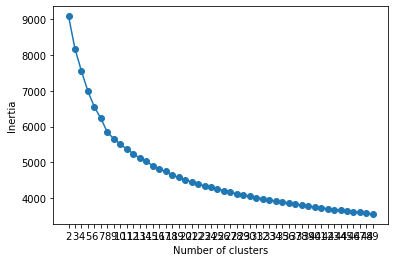

In [64]:
# 8 clusters show good cut of an elbow point
minmax = MinMaxScaler()
X_3step =  pd.DataFrame(minmax.fit_transform(X_2step), columns=X_2step.columns)

inertia = {}
for i in range(2,50):
    kmeans = KMeans(n_clusters=i, random_state=123)
    kmeans.fit_predict(X_3step[cont_vars])
    inertia.update({i:kmeans.inertia_})

inertia_df = pd.Series(inertia)
plt.plot(inertia_df,marker="o")
plt.xticks(inertia_df.index)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [11]:
X_2step

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,key_Missing
id,,,,,,,,,,,,,,,,,,,,,
0,1091.578753,0.642286,0.925484,0.707073,0.002001,-1.995504,-1.486563,-5.647440,0.006314,0.857112,...,0,0,0,0,0,0,0,1,0,0
1,1019.539204,0.054866,0.856323,0.835545,0.000996,-0.829132,-1.450249,-3.999327,0.009732,0.843523,...,0,0,0,0,0,1,0,0,0,0
2,1037.904924,0.140532,0.434036,0.783524,-0.002694,-1.769028,-1.421259,-7.903503,0.005596,0.652331,...,0,0,1,0,0,0,0,0,0,0
3,1185.646548,0.488660,0.765006,0.552685,0.000608,-2.355932,-1.658706,-10.324775,0.007769,0.673496,...,0,0,0,0,0,0,0,0,0,0
4,959.402294,0.493017,0.779893,0.740982,0.002033,-2.355026,-1.102492,-8.072694,0.008202,0.860994,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1155.607489,0.140532,0.865414,0.511234,0.002913,-1.749831,-1.715360,-5.893307,0.005943,0.422089,...,0,0,0,0,0,0,0,0,0,0
39996,1032.069400,0.067488,0.820262,0.889685,0.001225,-2.096186,-1.652700,-2.827285,0.009035,0.889171,...,0,0,1,0,0,0,0,0,0,0
39997,944.061266,0.877431,0.639582,0.292671,0.001974,-2.201258,-1.974560,-11.271628,0.010045,0.421838,...,0,0,0,0,0,0,0,1,0,0


In [19]:
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, max_iter=500, n_init=20, random_state=123)
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]

minmax = MinMaxScaler(feature_range=(0.1,1,1))
X_3step =  pd.DataFrame(minmax.fit_transform(X_2step), columns=X_2step.columns)

X_kmeans = kmeans.fit_transform(X_3step[cont_vars])
X_kmeans = pd.DataFrame(X_kmeans, columns=cluster_cols, index = X.index)

X_3step = X_3step.join(X_kmeans)
X_3step

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_11.0,key_Missing,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,0.1,0.1,0.695181,0.546457,0.679398,0.516037,0.307385,0.585809,0.686943,0.878982
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,0.1,0.1,0.518975,0.434133,0.953212,0.320216,0.582449,0.170143,0.575520,0.888018
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,0.1,0.1,0.228376,0.544202,0.838803,0.598171,0.673419,0.583477,0.543307,0.828197
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,0.1,0.1,0.569140,0.442754,0.465877,0.560904,0.303811,0.624888,0.404666,0.741319
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,0.1,0.1,0.538626,0.394977,0.696305,0.456338,0.348926,0.550104,0.596653,0.833051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.640169,0.228542,0.867790,0.543263,0.106094,0.552254,0.399161,0.732567,0.207538,0.407891,...,0.1,0.1,0.592734,0.591694,0.757786,0.553015,0.609365,0.594835,0.423288,0.811821
39996,0.555804,0.167606,0.814923,0.870321,0.104687,0.466720,0.432323,0.890105,0.448406,0.877338,...,0.1,0.1,0.472894,0.382367,0.934594,0.175619,0.543401,0.407817,0.557871,0.867020
39997,0.495703,0.843287,0.603371,0.354381,0.105311,0.440773,0.261981,0.456219,0.527088,0.407639,...,0.1,0.1,0.983387,0.937145,0.215899,1.005287,0.645662,1.033437,0.715445,0.915317
39998,0.561126,0.228542,0.562603,0.710244,0.103948,0.729534,0.571384,0.639042,0.301581,0.867308,...,0.1,0.1,0.316033,0.385407,0.835543,0.449093,0.535379,0.299627,0.507995,0.817109


## Feature engineering 2- interaction

In [36]:
interact_fe = CombineWithReferenceFeature(
    variables_to_combine = cont_vars,
    reference_variables=cont_vars,
    operations=['sub', 'div','add'])

X_4step = interact_fe.fit_transform(X_3step)
X_4step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,song_duration_ms_add_audio_valence,acousticness_add_audio_valence,danceability_add_audio_valence,energy_add_audio_valence,instrumentalness_add_audio_valence,liveness_add_audio_valence,loudness_add_audio_valence,speechiness_add_audio_valence,tempo_add_audio_valence,audio_valence_add_audio_valence
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,1.441559,1.492237,1.783240,1.557624,0.950450,1.336701,1.365367,1.590316,1.081528,1.690233
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,1.378705,0.988533,1.688603,1.654991,0.935953,1.611081,1.370927,1.661341,1.334198,1.662916
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,1.199088,0.867840,1.002003,1.417875,0.740719,1.186812,1.194111,1.268578,0.819828,1.278597
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,1.321253,1.179532,1.410796,1.239655,0.764743,1.063146,1.089715,1.165441,1.010372,1.321141
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,1.355197,1.371614,1.616675,1.590829,0.954378,1.251817,1.572534,1.469604,1.232514,1.698035


## Feature 3: polynomial features


In [47]:
# create 3 degree polynomial features
poly_fe = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_5step_temp = poly_fe.fit_transform(X_4step[cont_vars])
poly_fe_name = poly_fe.get_feature_names(X_4step[cont_vars].columns)
X_5step_temp = pd.DataFrame(X_5step_temp, columns =poly_fe_name)
X_5step = pd.concat([X_4step, X_5step_temp], axis=1, join='inner')
X_5step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,0.413827,0.131285,0.469313,0.041650,0.148887,0.532238,0.013213,0.047234,0.168850,0.603600
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,0.571545,0.346240,0.572630,0.209751,0.346897,0.573717,0.127066,0.210149,0.347555,0.574805
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,0.249190,0.071488,0.253158,0.020509,0.072626,0.257188,0.005884,0.020835,0.073783,0.261283
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,0.128688,0.089162,0.168375,0.061776,0.116660,0.220302,0.042802,0.080828,0.152637,0.288242
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,0.239005,0.147695,0.326980,0.091269,0.202060,0.447338,0.056401,0.124865,0.276436,0.611998


## Feature scaling before modeling

In [95]:
minmax_v2 = StandardScaler()
X_5step_scaled =  pd.DataFrame(minmax_v2.fit_transform(X_5step), columns=X_5step.columns)
X_5step_scaled.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,0.516346,1.328643,1.376518,0.104510,-0.217778,-0.300535,0.307741,0.453796,-1.405563,0.669562,...,0.229905,-0.629958,0.579372,-1.040798,-0.642042,0.774967,-0.945805,-1.064984,-0.598481,0.599056
1,-0.081323,-0.728254,0.843398,0.740795,-0.224824,1.826783,0.463230,0.962532,0.388418,0.590145,...,0.865437,1.083681,1.095451,0.629529,1.214850,0.988533,0.078606,0.499746,0.754491,0.486471
2,0.071046,-0.428285,-2.411751,0.483149,-0.250676,0.112529,0.587358,-0.242602,-1.781984,-0.527168,...,-0.433504,-1.106660,-0.500340,-1.250862,-1.357201,-0.641217,-1.011753,-1.318532,-1.318234,-0.739356
3,1.296771,0.790712,0.139491,-0.660129,-0.227540,-0.957912,-0.429334,-0.989996,-0.641775,-0.403482,...,-0.919069,-0.965763,-0.923834,-0.840809,-0.944268,-0.831138,-0.679575,-0.742328,-0.721232,-0.633950
4,-0.580244,0.805969,0.254252,0.272450,-0.217555,-0.956260,1.952238,-0.294828,-0.414805,0.692246,...,-0.474546,-0.499136,-0.131592,-0.547755,-0.143403,0.337830,-0.557220,-0.319375,0.216048,0.631890


## Feature selection before modelling

In [112]:
# remove duplicates columns
uniq, idxs = np.unique(X_5step_scaled, return_index=True, axis=1)
X_5step_dropduplicates = pd.DataFrame(uniq, index=X_5step_scaled.index, columns=X_5step_scaled.columns[idxs])
X_5step_dropduplicates

,tempo_sub_acousticness,tempo_sub_danceability,cluster5,tempo_sub_song_duration_ms,tempo,tempo_sub_audio_valence,instrumentalness_sub_acousticness,tempo_div_acousticness,tempo_div_danceability,tempo_add_liveness,...,acousticness danceability speechiness,danceability_div_tempo,acousticness loudness audio_valence,acousticness danceability audio_valence,acousticness danceability^2,acousticness danceability energy,key_10.0,acousticness_div_tempo,liveness_na,acousticness danceability loudness
0,-2.073020,-2.009789,-1.698478,-1.427683,-1.405563,-1.372231,-1.319300,-1.313529,-1.310715,-1.280206,...,2.550305,2.630035,2.637282,2.769245,2.840433,2.840677,2.880625,2.963994,2.964713,3.002341
1,0.912423,-0.338907,0.197464,0.365819,0.388418,-0.185744,0.565389,1.016668,-0.197330,1.565923,...,-0.391785,-0.183657,-0.510431,-0.471037,-0.464554,-0.419959,-0.347147,-0.761834,-0.337301,-0.491409
2,-0.641438,0.489686,0.824496,-1.536980,-1.781984,-0.736857,0.278216,-0.964578,-0.492871,-1.279967,...,-0.906252,0.194493,-0.354476,-0.947265,-1.085633,-0.889679,-0.347147,0.703274,-0.337301,-0.874144
3,-1.119615,-0.560303,-1.723114,-1.148303,-0.641775,-0.109685,-0.830035,-1.059813,-0.597611,-1.155034,...,0.340860,0.363076,0.616809,0.702264,0.821365,0.741510,-0.347147,1.037681,-0.337301,0.865432
4,-1.000965,-0.482060,-1.412148,-0.078549,-0.414805,-0.765470,-0.839463,-1.010675,-0.486760,-0.980894,...,0.793391,0.185312,3.173977,1.376151,0.936890,1.472722,2.880625,0.851952,-0.337301,2.634917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-0.534834,-1.810329,0.382985,-1.840349,-1.600055,0.358220,0.296220,-0.867453,-1.353476,-1.116966,...,-0.101995,2.895061,-0.999292,-0.721863,-0.051879,-0.451731,-0.347147,0.450131,-0.337301,-0.397575
39996,0.656401,-0.397178,-0.071686,0.008335,0.022426,-0.610415,0.525557,0.584977,-0.318097,-0.319474,...,-0.306776,-0.043881,-0.611653,-0.407321,-0.494366,-0.338908,-0.347147,-0.667579,-0.337301,-0.686539
39997,-1.699982,0.999132,0.633172,0.797205,0.552426,1.713432,-2.075125,-1.100084,0.758031,-0.048735,...,0.648020,-0.880136,-0.222193,0.300183,0.929898,0.283887,2.880625,1.216391,-0.337301,0.380123
39998,-0.163643,0.110355,-0.126981,-0.856501,-0.966587,-1.190107,0.287955,-0.529269,-0.365351,0.276009,...,-0.647127,0.015963,0.118947,-0.474494,-0.777976,-0.618189,-0.347147,-0.077501,-0.337301,-0.479411


In [135]:
feature_sel_pipe1 = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicates', DropDuplicateFeatures()),
    # ('correlated', DropCorrelatedFeatures())
])

# X_5step_feature_sel_v1 = feature_sel_pipe1.fit_transform(X_5step_dropduplicates)

X_5step_feature_sel_v1_1 = feature_sel_pipe1.fit_transform(X_5step_dropduplicates)

In [141]:
# shuffle feature selector
model = LGBMClassifier(random_state=123)

sel1 = SelectByShuffling(
    estimator = model,
    variables = None,
    scoring = 'roc_auc',
    threshold = 0.0005,
    cv = 3
)

sel1.fit(X_5step_feature_sel_v1_1, y)

SelectByShuffling(estimator=LGBMClassifier(random_state=123), threshold=0.0005)

<AxesSubplot:>

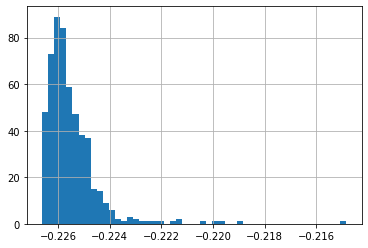

In [147]:
sel1.initial_model_performance_
pd.Series(sel1.performance_drifts_).hist(bins = 50)

In [140]:
# recursive feature selection
model = GradientBoostingClassifier(
    n_estimators = 10,
    max_depth = 2,
    random_state = 123
)

sel = RecursiveFeatureElimination(
    variables = None,
    estimator = model,
    scoring = 'roc_auc',
    threshold = 0.0005,
    cv  =2
)

sel.fit(X_5step_feature_sel_v1_1, y)

KeyboardInterrupt: 

## Modelling & hyperparameter tuning (optuna) - individual models


In [125]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Define the helper function so that it can be reused
def tune(objective, n_trials = 100):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

In [126]:
def xgb_objective(trial):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 0, 1000),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 20),
        'learning_rate' : trial.suggest_discrete_uniform('learning_rate', 0.01, 0.1, 0.01),
        'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 1, 100),
        'subsample' : trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    }
    
    xgb_m = XGBClassifier(**param, random_state=123 , eval_metric='aucpr')
    scores = cross_val_score(
        xgb_m, X_5step_feature_sel_v1.to_numpy(), y, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

xgb_params = tune(xgb_objective)

[I 2022-01-31 00:02:49,623] A new study created in memory with name: no-name-369e39f5-7530-42eb-841c-e93673cb061f
[I 2022-01-31 00:14:33,722] Trial 0 finished with value: 0.5419991078699408 and parameters: {'n_estimators': 616, 'max_depth': 12, 'min_child_weight': 8, 'learning_rate': 0.060000000000000005, 'scale_pos_weight': 86, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.5419991078699408.
[I 2022-01-31 00:21:31,676] Trial 1 finished with value: 0.5436723029592478 and parameters: {'n_estimators': 839, 'max_depth': 12, 'min_child_weight': 18, 'learning_rate': 0.04, 'scale_pos_weight': 61, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.5436723029592478.
[I 2022-01-31 00:22:59,905] Trial 2 finished with value: 0.5669898849607206 and parameters: {'n_estimators': 974, 'max_depth': 1, 'min_child_weight': 18, 'learning_rate': 0.04, 'scale_pos_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 2 with value: 0.566989884

Best score: 0.5686126303023216

Optimized parameters: {'n_estimators': 881, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.01, 'scale_pos_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}



In [127]:
from lightgbm import LGBMClassifier

In [128]:
def lgbm_objective(trial):

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    lgbm_m = LGBMClassifier(**param, random_state=123)
    scores = cross_val_score(
        lgbm_m, X_5step_feature_sel_v1.to_numpy(), y, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

lgbm_params = tune(lgbm_objective, n_trials=50)



[I 2022-01-31 06:47:12,134] A new study created in memory with name: no-name-5a2a9a03-2baf-45f6-b0ec-91cb6d02efaa


[LightGBM] [Warning] feature_fraction is set=0.7853363232204944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7853363232204944
[LightGBM] [Warning] lambda_l1 is set=0.00964025548754244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00964025548754244
[LightGBM] [Warning] bagging_fraction is set=0.937599051262347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.937599051262347
[LightGBM] [Warning] lambda_l2 is set=0.07679078280464535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07679078280464535
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7853363232204944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7853363232204944
[LightGBM] [Warning] lambda_l1 is set=0.00964025548754244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00964025548754244
[LightGBM] [Warning] bagging_frac

[I 2022-01-31 06:47:25,517] Trial 0 finished with value: 0.5414903767052448 and parameters: {'lambda_l1': 0.00964025548754244, 'lambda_l2': 0.07679078280464535, 'num_leaves': 251, 'feature_fraction': 0.7853363232204944, 'bagging_fraction': 0.937599051262347, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 0 with value: 0.5414903767052448.


[LightGBM] [Warning] feature_fraction is set=0.5774719867027303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774719867027303
[LightGBM] [Warning] lambda_l1 is set=1.0454488482972647e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0454488482972647e-05
[LightGBM] [Warning] bagging_fraction is set=0.5530773559343185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5530773559343185
[LightGBM] [Warning] lambda_l2 is set=2.786005596975362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.786005596975362
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5774719867027303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774719867027303
[LightGBM] [Warning] lambda_l1 is set=1.0454488482972647e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0454488482972647e-05
[LightGBM] [Warning] ba

[I 2022-01-31 06:47:30,809] Trial 1 finished with value: 0.5424585842052878 and parameters: {'lambda_l1': 1.0454488482972647e-05, 'lambda_l2': 2.786005596975362, 'num_leaves': 97, 'feature_fraction': 0.5774719867027303, 'bagging_fraction': 0.5530773559343185, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 1 with value: 0.5424585842052878.


[LightGBM] [Warning] feature_fraction is set=0.436582616829184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.436582616829184
[LightGBM] [Warning] lambda_l1 is set=0.001603084031694417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001603084031694417
[LightGBM] [Warning] bagging_fraction is set=0.7977797923875365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7977797923875365
[LightGBM] [Warning] lambda_l2 is set=6.000650514882342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.000650514882342
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.436582616829184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.436582616829184
[LightGBM] [Warning] lambda_l1 is set=0.001603084031694417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001603084031694417
[LightGBM] [Warning] bagging_fracti

[I 2022-01-31 06:47:35,953] Trial 2 finished with value: 0.5535851170137616 and parameters: {'lambda_l1': 0.001603084031694417, 'lambda_l2': 6.000650514882342, 'num_leaves': 86, 'feature_fraction': 0.436582616829184, 'bagging_fraction': 0.7977797923875365, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 2 with value: 0.5535851170137616.


[LightGBM] [Warning] feature_fraction is set=0.8707948824768738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8707948824768738
[LightGBM] [Warning] lambda_l1 is set=6.555060563894527e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.555060563894527e-05
[LightGBM] [Warning] bagging_fraction is set=0.7513470319209867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513470319209867
[LightGBM] [Warning] lambda_l2 is set=6.7451743475781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7451743475781
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8707948824768738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8707948824768738
[LightGBM] [Warning] lambda_l1 is set=6.555060563894527e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.555060563894527e-05
[LightGBM] [Warning] bagging_fr

[I 2022-01-31 06:47:45,464] Trial 3 finished with value: 0.545070087617437 and parameters: {'lambda_l1': 6.555060563894527e-05, 'lambda_l2': 6.7451743475781, 'num_leaves': 146, 'feature_fraction': 0.8707948824768738, 'bagging_fraction': 0.7513470319209867, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 2 with value: 0.5535851170137616.


[LightGBM] [Warning] feature_fraction is set=0.7331685456696355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7331685456696355
[LightGBM] [Warning] lambda_l1 is set=5.3067338311300844e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3067338311300844e-08
[LightGBM] [Warning] bagging_fraction is set=0.49651730171875574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49651730171875574
[LightGBM] [Warning] lambda_l2 is set=2.0830219760918064e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0830219760918064e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7331685456696355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7331685456696355
[LightGBM] [Warning] lambda_l1 is set=5.3067338311300844e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3067338311300844e-08
[LightGBM] 

[I 2022-01-31 06:47:57,271] Trial 4 finished with value: 0.5367234390621046 and parameters: {'lambda_l1': 5.3067338311300844e-08, 'lambda_l2': 2.0830219760918064e-08, 'num_leaves': 218, 'feature_fraction': 0.7331685456696355, 'bagging_fraction': 0.49651730171875574, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 2 with value: 0.5535851170137616.


[LightGBM] [Warning] feature_fraction is set=0.43941491111911607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43941491111911607
[LightGBM] [Warning] lambda_l1 is set=0.0007481598040660198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007481598040660198
[LightGBM] [Warning] bagging_fraction is set=0.5090345966162425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090345966162425
[LightGBM] [Warning] lambda_l2 is set=4.678283078867346e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.678283078867346e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.43941491111911607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43941491111911607
[LightGBM] [Warning] lambda_l1 is set=0.0007481598040660198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007481598040660198
[LightGBM] [War

[I 2022-01-31 06:48:04,345] Trial 5 finished with value: 0.5382559696744961 and parameters: {'lambda_l1': 0.0007481598040660198, 'lambda_l2': 4.678283078867346e-06, 'num_leaves': 187, 'feature_fraction': 0.43941491111911607, 'bagging_fraction': 0.5090345966162425, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 2 with value: 0.5535851170137616.


[LightGBM] [Warning] feature_fraction is set=0.7125078057167292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7125078057167292
[LightGBM] [Warning] lambda_l1 is set=0.007404516919919117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007404516919919117
[LightGBM] [Warning] bagging_fraction is set=0.8604313149842051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604313149842051
[LightGBM] [Warning] lambda_l2 is set=3.92927095771252e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.92927095771252e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7125078057167292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7125078057167292
[LightGBM] [Warning] lambda_l1 is set=0.007404516919919117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007404516919919117
[LightGBM] [Warning] bagg

[I 2022-01-31 06:48:07,853] Trial 6 finished with value: 0.558368439763671 and parameters: {'lambda_l1': 0.007404516919919117, 'lambda_l2': 3.92927095771252e-07, 'num_leaves': 40, 'feature_fraction': 0.7125078057167292, 'bagging_fraction': 0.8604313149842051, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 6 with value: 0.558368439763671.


[LightGBM] [Warning] feature_fraction is set=0.7335930421391863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335930421391863
[LightGBM] [Warning] lambda_l1 is set=2.3096476142079595e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3096476142079595e-05
[LightGBM] [Warning] bagging_fraction is set=0.6630090090193403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6630090090193403
[LightGBM] [Warning] lambda_l2 is set=0.003741790762964638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003741790762964638
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7335930421391863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335930421391863
[LightGBM] [Warning] lambda_l1 is set=2.3096476142079595e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3096476142079595e-05
[LightGBM] [Warni

[I 2022-01-31 06:48:14,936] Trial 7 finished with value: 0.5416685292784947 and parameters: {'lambda_l1': 2.3096476142079595e-05, 'lambda_l2': 0.003741790762964638, 'num_leaves': 123, 'feature_fraction': 0.7335930421391863, 'bagging_fraction': 0.6630090090193403, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 6 with value: 0.558368439763671.


[LightGBM] [Warning] feature_fraction is set=0.8416637664189428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8416637664189428
[LightGBM] [Warning] lambda_l1 is set=8.798754573459544e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.798754573459544e-05
[LightGBM] [Warning] bagging_fraction is set=0.7613658196669784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7613658196669784
[LightGBM] [Warning] lambda_l2 is set=9.138997371850806e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.138997371850806e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8416637664189428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8416637664189428
[LightGBM] [Warning] lambda_l1 is set=8.798754573459544e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.798754573459544e-05
[LightGBM] [Warning

[I 2022-01-31 06:48:25,269] Trial 8 finished with value: 0.5408609453636519 and parameters: {'lambda_l1': 8.798754573459544e-05, 'lambda_l2': 9.138997371850806e-06, 'num_leaves': 173, 'feature_fraction': 0.8416637664189428, 'bagging_fraction': 0.7613658196669784, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 6 with value: 0.558368439763671.


[LightGBM] [Warning] feature_fraction is set=0.697789208763214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.697789208763214
[LightGBM] [Warning] lambda_l1 is set=0.0339521376808396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0339521376808396
[LightGBM] [Warning] bagging_fraction is set=0.5631265594744567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5631265594744567
[LightGBM] [Warning] lambda_l2 is set=8.071378939739114e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.071378939739114e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.697789208763214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.697789208763214
[LightGBM] [Warning] lambda_l1 is set=0.0339521376808396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0339521376808396
[LightGBM] [Warning] bagging_fracti

[I 2022-01-31 06:48:37,014] Trial 9 finished with value: 0.5336266952664476 and parameters: {'lambda_l1': 0.0339521376808396, 'lambda_l2': 8.071378939739114e-06, 'num_leaves': 227, 'feature_fraction': 0.697789208763214, 'bagging_fraction': 0.5631265594744567, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 6 with value: 0.558368439763671.


[LightGBM] [Warning] feature_fraction is set=0.9722380651514162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722380651514162
[LightGBM] [Warning] lambda_l1 is set=1.9294354900482888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9294354900482888
[LightGBM] [Warning] bagging_fraction is set=0.9873466370011006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873466370011006
[LightGBM] [Warning] lambda_l2 is set=1.1337439219419316e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1337439219419316e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9722380651514162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722380651514162
[LightGBM] [Warning] lambda_l1 is set=1.9294354900482888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9294354900482888
[LightGBM] [Warning] bagging_

[I 2022-01-31 06:48:38,841] Trial 10 finished with value: 0.5597257244940557 and parameters: {'lambda_l1': 1.9294354900482888, 'lambda_l2': 1.1337439219419316e-08, 'num_leaves': 2, 'feature_fraction': 0.9722380651514162, 'bagging_fraction': 0.9873466370011006, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 10 with value: 0.5597257244940557.


[LightGBM] [Warning] feature_fraction is set=0.975701099490055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975701099490055
[LightGBM] [Warning] lambda_l1 is set=6.332001649123096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.332001649123096
[LightGBM] [Warning] bagging_fraction is set=0.995364903582475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995364903582475
[LightGBM] [Warning] lambda_l2 is set=1.3775062068399943e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3775062068399943e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.975701099490055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975701099490055
[LightGBM] [Warning] lambda_l1 is set=6.332001649123096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.332001649123096
[LightGBM] [Warning] bagging_fraction i

[I 2022-01-31 06:48:40,936] Trial 11 finished with value: 0.5668435299137886 and parameters: {'lambda_l1': 6.332001649123096, 'lambda_l2': 1.3775062068399943e-08, 'num_leaves': 4, 'feature_fraction': 0.975701099490055, 'bagging_fraction': 0.995364903582475, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 11 with value: 0.5668435299137886.


[LightGBM] [Warning] feature_fraction is set=0.9877936959236435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9877936959236435
[LightGBM] [Warning] lambda_l1 is set=4.748400625824833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.748400625824833
[LightGBM] [Warning] bagging_fraction is set=0.9631627894158276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631627894158276
[LightGBM] [Warning] lambda_l2 is set=1.234745573941478e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.234745573941478e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9877936959236435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9877936959236435
[LightGBM] [Warning] lambda_l1 is set=4.748400625824833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.748400625824833
[LightGBM] [Warning] bagging_fracti

[I 2022-01-31 06:48:42,720] Trial 12 finished with value: 0.5595543557936044 and parameters: {'lambda_l1': 4.748400625824833, 'lambda_l2': 1.234745573941478e-08, 'num_leaves': 2, 'feature_fraction': 0.9877936959236435, 'bagging_fraction': 0.9631627894158276, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 11 with value: 0.5668435299137886.


[LightGBM] [Warning] feature_fraction is set=0.9859408299601723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9859408299601723
[LightGBM] [Warning] lambda_l1 is set=9.90605637686986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.90605637686986
[LightGBM] [Warning] bagging_fraction is set=0.9962604981979869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9962604981979869
[LightGBM] [Warning] lambda_l2 is set=4.372974341256061e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.372974341256061e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9859408299601723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9859408299601723
[LightGBM] [Warning] lambda_l1 is set=9.90605637686986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.90605637686986
[LightGBM] [Warning] bagging_fraction i

[I 2022-01-31 06:48:45,059] Trial 13 finished with value: 0.5671893769263703 and parameters: {'lambda_l1': 9.90605637686986, 'lambda_l2': 4.372974341256061e-07, 'num_leaves': 5, 'feature_fraction': 0.9859408299601723, 'bagging_fraction': 0.9962604981979869, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.9084867778828347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9084867778828347
[LightGBM] [Warning] lambda_l1 is set=0.5264724465001859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5264724465001859
[LightGBM] [Warning] bagging_fraction is set=0.8949688696355705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8949688696355705
[LightGBM] [Warning] lambda_l2 is set=4.2541238096936605e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2541238096936605e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9084867778828347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9084867778828347
[LightGBM] [Warning] lambda_l1 is set=0.5264724465001859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5264724465001859
[LightGBM] [Warning] bagging_

[I 2022-01-31 06:48:49,606] Trial 14 finished with value: 0.5569157133813317 and parameters: {'lambda_l1': 0.5264724465001859, 'lambda_l2': 4.2541238096936605e-07, 'num_leaves': 50, 'feature_fraction': 0.9084867778828347, 'bagging_fraction': 0.8949688696355705, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.9368228807050327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9368228807050327
[LightGBM] [Warning] lambda_l1 is set=0.2261035205889347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2261035205889347
[LightGBM] [Warning] bagging_fraction is set=0.4006967723042525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4006967723042525
[LightGBM] [Warning] lambda_l2 is set=0.0006875085030747213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006875085030747213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9368228807050327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9368228807050327
[LightGBM] [Warning] lambda_l1 is set=0.2261035205889347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2261035205889347
[LightGBM] [Warning] bagging_fr

[I 2022-01-31 06:48:53,858] Trial 15 finished with value: 0.5464538053293909 and parameters: {'lambda_l1': 0.2261035205889347, 'lambda_l2': 0.0006875085030747213, 'num_leaves': 46, 'feature_fraction': 0.9368228807050327, 'bagging_fraction': 0.4006967723042525, 'bagging_freq': 1, 'min_child_samples': 65}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.6116958044603485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6116958044603485
[LightGBM] [Warning] lambda_l1 is set=6.2886912326187545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2886912326187545
[LightGBM] [Warning] bagging_fraction is set=0.8607372349313804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8607372349313804
[LightGBM] [Warning] lambda_l2 is set=2.81392620302735e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.81392620302735e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6116958044603485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6116958044603485
[LightGBM] [Warning] lambda_l1 is set=6.2886912326187545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2886912326187545
[LightGBM] [Warning] bagging_frac

[I 2022-01-31 06:48:56,946] Trial 16 finished with value: 0.5636437971494728 and parameters: {'lambda_l1': 6.2886912326187545, 'lambda_l2': 2.81392620302735e-07, 'num_leaves': 28, 'feature_fraction': 0.6116958044603485, 'bagging_fraction': 0.8607372349313804, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.8090120128246616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8090120128246616
[LightGBM] [Warning] lambda_l1 is set=0.1852874134150474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1852874134150474
[LightGBM] [Warning] bagging_fraction is set=0.6648482149866731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6648482149866731
[LightGBM] [Warning] lambda_l2 is set=2.2912177725445834e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2912177725445834e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8090120128246616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8090120128246616
[LightGBM] [Warning] lambda_l1 is set=0.1852874134150474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1852874134150474
[LightGBM] [Warning] bagging_

[I 2022-01-31 06:49:02,733] Trial 17 finished with value: 0.5447563436266617 and parameters: {'lambda_l1': 0.1852874134150474, 'lambda_l2': 2.2912177725445834e-05, 'num_leaves': 79, 'feature_fraction': 0.8090120128246616, 'bagging_fraction': 0.6648482149866731, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.895391810898357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895391810898357
[LightGBM] [Warning] lambda_l1 is set=2.1555543436256357e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1555543436256357e-07
[LightGBM] [Warning] bagging_fraction is set=0.9946661114505755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9946661114505755
[LightGBM] [Warning] lambda_l2 is set=1.1374471449201443e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1374471449201443e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.895391810898357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895391810898357
[LightGBM] [Warning] lambda_l1 is set=2.1555543436256357e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1555543436256357e-07
[LightGBM] [Warni

[I 2022-01-31 06:49:07,642] Trial 18 finished with value: 0.5553993601670364 and parameters: {'lambda_l1': 2.1555543436256357e-07, 'lambda_l2': 1.1374471449201443e-07, 'num_leaves': 61, 'feature_fraction': 0.895391810898357, 'bagging_fraction': 0.9946661114505755, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.9962912098641605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962912098641605
[LightGBM] [Warning] lambda_l1 is set=0.05438937616323319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05438937616323319
[LightGBM] [Warning] bagging_fraction is set=0.9030065908432138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9030065908432138
[LightGBM] [Warning] lambda_l2 is set=0.00013529807032831016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013529807032831016
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9962912098641605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962912098641605
[LightGBM] [Warning] lambda_l1 is set=0.05438937616323319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05438937616323319
[LightGBM] [Warning] bagg

[I 2022-01-31 06:49:10,884] Trial 19 finished with value: 0.5619361845036144 and parameters: {'lambda_l1': 0.05438937616323319, 'lambda_l2': 0.00013529807032831016, 'num_leaves': 20, 'feature_fraction': 0.9962912098641605, 'bagging_fraction': 0.9030065908432138, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.6049723005585375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6049723005585375
[LightGBM] [Warning] lambda_l1 is set=1.222951730599743e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.222951730599743e-06
[LightGBM] [Warning] bagging_fraction is set=0.8202372412044848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8202372412044848
[LightGBM] [Warning] lambda_l2 is set=8.561388261213837e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.561388261213837e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6049723005585375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6049723005585375
[LightGBM] [Warning] lambda_l1 is set=1.222951730599743e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.222951730599743e-06
[LightGBM] [Warning

[I 2022-01-31 06:49:16,263] Trial 20 finished with value: 0.546217049571076 and parameters: {'lambda_l1': 1.222951730599743e-06, 'lambda_l2': 8.561388261213837e-07, 'num_leaves': 102, 'feature_fraction': 0.6049723005585375, 'bagging_fraction': 0.8202372412044848, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.5364563858277998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5364563858277998
[LightGBM] [Warning] lambda_l1 is set=9.53652726403544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.53652726403544
[LightGBM] [Warning] bagging_fraction is set=0.9196036137926095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9196036137926095
[LightGBM] [Warning] lambda_l2 is set=6.271987893577942e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.271987893577942e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5364563858277998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5364563858277998
[LightGBM] [Warning] lambda_l1 is set=9.53652726403544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.53652726403544
[LightGBM] [Warning] bagging_fraction i

[I 2022-01-31 06:49:18,858] Trial 21 finished with value: 0.5647037165895645 and parameters: {'lambda_l1': 9.53652726403544, 'lambda_l2': 6.271987893577942e-08, 'num_leaves': 18, 'feature_fraction': 0.5364563858277998, 'bagging_fraction': 0.9196036137926095, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.5167241445949518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5167241445949518
[LightGBM] [Warning] lambda_l1 is set=1.54243989668167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.54243989668167
[LightGBM] [Warning] bagging_fraction is set=0.942234094167729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942234094167729
[LightGBM] [Warning] lambda_l2 is set=7.39120210755462e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.39120210755462e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5167241445949518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5167241445949518
[LightGBM] [Warning] lambda_l1 is set=1.54243989668167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.54243989668167
[LightGBM] [Warning] bagging_fraction is se

[I 2022-01-31 06:49:21,185] Trial 22 finished with value: 0.5656686132441971 and parameters: {'lambda_l1': 1.54243989668167, 'lambda_l2': 7.39120210755462e-08, 'num_leaves': 16, 'feature_fraction': 0.5167241445949518, 'bagging_fraction': 0.942234094167729, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.49043186650352477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49043186650352477
[LightGBM] [Warning] lambda_l1 is set=0.9603986228790398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9603986228790398
[LightGBM] [Warning] bagging_fraction is set=0.9805738391448673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805738391448673
[LightGBM] [Warning] lambda_l2 is set=2.743900796658878e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.743900796658878e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.49043186650352477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49043186650352477
[LightGBM] [Warning] lambda_l1 is set=0.9603986228790398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9603986228790398
[LightGBM] [Warning] baggin

[I 2022-01-31 06:49:25,060] Trial 23 finished with value: 0.5576060926406526 and parameters: {'lambda_l1': 0.9603986228790398, 'lambda_l2': 2.743900796658878e-06, 'num_leaves': 64, 'feature_fraction': 0.49043186650352477, 'bagging_fraction': 0.9805738391448673, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.6473015849692757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6473015849692757
[LightGBM] [Warning] lambda_l1 is set=1.05941594297958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.05941594297958
[LightGBM] [Warning] bagging_fraction is set=0.9369859354232226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9369859354232226
[LightGBM] [Warning] lambda_l2 is set=5.1870090863310495e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1870090863310495e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6473015849692757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6473015849692757
[LightGBM] [Warning] lambda_l1 is set=1.05941594297958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.05941594297958
[LightGBM] [Warning] bagging_fraction

[I 2022-01-31 06:49:26,796] Trial 24 finished with value: 0.5651079582445871 and parameters: {'lambda_l1': 1.05941594297958, 'lambda_l2': 5.1870090863310495e-08, 'num_leaves': 3, 'feature_fraction': 0.6473015849692757, 'bagging_fraction': 0.9369859354232226, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.9349592875530416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9349592875530416
[LightGBM] [Warning] lambda_l1 is set=0.09597630611763348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09597630611763348
[LightGBM] [Warning] bagging_fraction is set=0.8670968716050913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8670968716050913
[LightGBM] [Warning] lambda_l2 is set=1.1362591628056754e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1362591628056754e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9349592875530416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9349592875530416
[LightGBM] [Warning] lambda_l1 is set=0.09597630611763348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09597630611763348
[LightGBM] [Warning] bagg

[I 2022-01-31 06:49:30,371] Trial 25 finished with value: 0.558689347135401 and parameters: {'lambda_l1': 0.09597630611763348, 'lambda_l2': 1.1362591628056754e-06, 'num_leaves': 30, 'feature_fraction': 0.9349592875530416, 'bagging_fraction': 0.8670968716050913, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.5285428879328042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285428879328042
[LightGBM] [Warning] lambda_l1 is set=1.6457847959333027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6457847959333027
[LightGBM] [Warning] bagging_fraction is set=0.9536450381346847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9536450381346847
[LightGBM] [Warning] lambda_l2 is set=6.389591973452728e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.389591973452728e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5285428879328042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5285428879328042
[LightGBM] [Warning] lambda_l1 is set=1.6457847959333027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6457847959333027
[LightGBM] [Warning] bagging_fr

[I 2022-01-31 06:49:34,454] Trial 26 finished with value: 0.5565131757903362 and parameters: {'lambda_l1': 1.6457847959333027, 'lambda_l2': 6.389591973452728e-05, 'num_leaves': 64, 'feature_fraction': 0.5285428879328042, 'bagging_fraction': 0.9536450381346847, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.7932264172707066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7932264172707066
[LightGBM] [Warning] lambda_l1 is set=9.853220218153663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.853220218153663
[LightGBM] [Warning] bagging_fraction is set=0.8172656890507985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172656890507985
[LightGBM] [Warning] lambda_l2 is set=1.0212140835165158e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0212140835165158e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7932264172707066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7932264172707066
[LightGBM] [Warning] lambda_l1 is set=9.853220218153663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.853220218153663
[LightGBM] [Warning] bagging_frac

[I 2022-01-31 06:49:37,541] Trial 27 finished with value: 0.5628198132482588 and parameters: {'lambda_l1': 9.853220218153663, 'lambda_l2': 1.0212140835165158e-07, 'num_leaves': 21, 'feature_fraction': 0.7932264172707066, 'bagging_fraction': 0.8172656890507985, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.8457962950872979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8457962950872979
[LightGBM] [Warning] lambda_l1 is set=0.01324179711482178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01324179711482178
[LightGBM] [Warning] bagging_fraction is set=0.9006400770184377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9006400770184377
[LightGBM] [Warning] lambda_l2 is set=0.0027165007072049527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027165007072049527
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8457962950872979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8457962950872979
[LightGBM] [Warning] lambda_l1 is set=0.01324179711482178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01324179711482178
[LightGBM] [Warning] baggin

[I 2022-01-31 06:49:45,338] Trial 28 finished with value: 0.5446958168944647 and parameters: {'lambda_l1': 0.01324179711482178, 'lambda_l2': 0.0027165007072049527, 'num_leaves': 123, 'feature_fraction': 0.8457962950872979, 'bagging_fraction': 0.9006400770184377, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.6623464065158974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6623464065158974
[LightGBM] [Warning] lambda_l1 is set=0.23911959776739855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23911959776739855
[LightGBM] [Warning] bagging_fraction is set=0.9429008198887805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9429008198887805
[LightGBM] [Warning] lambda_l2 is set=0.03398272292952249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03398272292952249
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6623464065158974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6623464065158974
[LightGBM] [Warning] lambda_l1 is set=0.23911959776739855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23911959776739855
[LightGBM] [Warning] bagging_fr

[I 2022-01-31 06:49:48,723] Trial 29 finished with value: 0.5587154305162013 and parameters: {'lambda_l1': 0.23911959776739855, 'lambda_l2': 0.03398272292952249, 'num_leaves': 38, 'feature_fraction': 0.6623464065158974, 'bagging_fraction': 0.9429008198887805, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.40812709103249556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40812709103249556
[LightGBM] [Warning] lambda_l1 is set=0.0035399968471111526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035399968471111526
[LightGBM] [Warning] bagging_fraction is set=0.9934380642849331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9934380642849331
[LightGBM] [Warning] lambda_l2 is set=4.224342517910214e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.224342517910214e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.40812709103249556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40812709103249556
[LightGBM] [Warning] lambda_l1 is set=0.0035399968471111526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035399968471111526
[LightGBM] [War

[I 2022-01-31 06:49:52,587] Trial 30 finished with value: 0.5521556574871391 and parameters: {'lambda_l1': 0.0035399968471111526, 'lambda_l2': 4.224342517910214e-08, 'num_leaves': 78, 'feature_fraction': 0.40812709103249556, 'bagging_fraction': 0.9934380642849331, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 13 with value: 0.5671893769263703.


[LightGBM] [Warning] feature_fraction is set=0.6549181528694273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549181528694273
[LightGBM] [Warning] lambda_l1 is set=1.9507389836797324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9507389836797324
[LightGBM] [Warning] bagging_fraction is set=0.9394477119816492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9394477119816492
[LightGBM] [Warning] lambda_l2 is set=1.5984538949536956e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5984538949536956e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6549181528694273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549181528694273
[LightGBM] [Warning] lambda_l1 is set=1.9507389836797324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9507389836797324
[LightGBM] [Warning] bagging_

[I 2022-01-31 06:49:54,638] Trial 31 finished with value: 0.569115565995852 and parameters: {'lambda_l1': 1.9507389836797324, 'lambda_l2': 1.5984538949536956e-07, 'num_leaves': 7, 'feature_fraction': 0.6549181528694273, 'bagging_fraction': 0.9394477119816492, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.5641967384607613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5641967384607613
[LightGBM] [Warning] lambda_l1 is set=2.46980244977002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.46980244977002
[LightGBM] [Warning] bagging_fraction is set=0.9320674118379589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320674118379589
[LightGBM] [Warning] lambda_l2 is set=1.9610324406665737e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9610324406665737e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5641967384607613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5641967384607613
[LightGBM] [Warning] lambda_l1 is set=2.46980244977002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.46980244977002
[LightGBM] [Warning] bagging_fraction

[I 2022-01-31 06:49:56,885] Trial 32 finished with value: 0.5664817659315966 and parameters: {'lambda_l1': 2.46980244977002, 'lambda_l2': 1.9610324406665737e-07, 'num_leaves': 12, 'feature_fraction': 0.5641967384607613, 'bagging_fraction': 0.9320674118379589, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.560469246119061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.560469246119061
[LightGBM] [Warning] lambda_l1 is set=3.057773578722827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.057773578722827
[LightGBM] [Warning] bagging_fraction is set=0.8772191154310088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8772191154310088
[LightGBM] [Warning] lambda_l2 is set=1.2560265511582903e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2560265511582903e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.560469246119061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.560469246119061
[LightGBM] [Warning] lambda_l1 is set=3.057773578722827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.057773578722827
[LightGBM] [Warning] bagging_fraction

[I 2022-01-31 06:49:59,071] Trial 33 finished with value: 0.5669748590491075 and parameters: {'lambda_l1': 3.057773578722827, 'lambda_l2': 1.2560265511582903e-06, 'num_leaves': 11, 'feature_fraction': 0.560469246119061, 'bagging_fraction': 0.8772191154310088, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.760293687078457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.760293687078457
[LightGBM] [Warning] lambda_l1 is set=0.42727416347398844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42727416347398844
[LightGBM] [Warning] bagging_fraction is set=0.8688483921307326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8688483921307326
[LightGBM] [Warning] lambda_l2 is set=2.617567131509708e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.617567131509708e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.760293687078457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.760293687078457
[LightGBM] [Warning] lambda_l1 is set=0.42727416347398844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42727416347398844
[LightGBM] [Warning] bagging_fr

[I 2022-01-31 06:50:03,159] Trial 34 finished with value: 0.5563431761691056 and parameters: {'lambda_l1': 0.42727416347398844, 'lambda_l2': 2.617567131509708e-05, 'num_leaves': 50, 'feature_fraction': 0.760293687078457, 'bagging_fraction': 0.8688483921307326, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.6678290903398972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678290903398972
[LightGBM] [Warning] lambda_l1 is set=0.018489485506890037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018489485506890037
[LightGBM] [Warning] bagging_fraction is set=0.7821308193198376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821308193198376
[LightGBM] [Warning] lambda_l2 is set=1.5235769949128134e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5235769949128134e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6678290903398972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678290903398972
[LightGBM] [Warning] lambda_l1 is set=0.018489485506890037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018489485506890037
[LightGBM] [Warning] 

[I 2022-01-31 06:50:06,652] Trial 35 finished with value: 0.554848117044283 and parameters: {'lambda_l1': 0.018489485506890037, 'lambda_l2': 1.5235769949128134e-06, 'num_leaves': 34, 'feature_fraction': 0.6678290903398972, 'bagging_fraction': 0.7821308193198376, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.6206292351277974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6206292351277974
[LightGBM] [Warning] lambda_l1 is set=3.39901160455729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.39901160455729
[LightGBM] [Warning] bagging_fraction is set=0.7283754520708463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283754520708463
[LightGBM] [Warning] lambda_l2 is set=2.566543868280571e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.566543868280571e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6206292351277974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6206292351277974
[LightGBM] [Warning] lambda_l1 is set=3.39901160455729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.39901160455729
[LightGBM] [Warning] bagging_fraction i

[I 2022-01-31 06:50:13,119] Trial 36 finished with value: 0.5515653802180837 and parameters: {'lambda_l1': 3.39901160455729, 'lambda_l2': 2.566543868280571e-08, 'num_leaves': 94, 'feature_fraction': 0.6206292351277974, 'bagging_fraction': 0.7283754520708463, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.47159046520306036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47159046520306036
[LightGBM] [Warning] lambda_l1 is set=1.4304410283957171e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4304410283957171e-08
[LightGBM] [Warning] bagging_fraction is set=0.9969200729917171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9969200729917171
[LightGBM] [Warning] lambda_l2 is set=6.447446506507858e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.447446506507858e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.47159046520306036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47159046520306036
[LightGBM] [Warning] lambda_l1 is set=1.4304410283957171e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4304410283957171e-08
[LightGBM] 

[I 2022-01-31 06:50:19,074] Trial 37 finished with value: 0.5519513170375292 and parameters: {'lambda_l1': 1.4304410283957171e-08, 'lambda_l2': 6.447446506507858e-07, 'num_leaves': 143, 'feature_fraction': 0.47159046520306036, 'bagging_fraction': 0.9969200729917171, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.5663753843726871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663753843726871
[LightGBM] [Warning] lambda_l1 is set=0.08252365887628685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08252365887628685
[LightGBM] [Warning] bagging_fraction is set=0.8422295857450111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8422295857450111
[LightGBM] [Warning] lambda_l2 is set=0.9740573944000804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9740573944000804
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5663753843726871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663753843726871
[LightGBM] [Warning] lambda_l1 is set=0.08252365887628685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08252365887628685
[LightGBM] [Warning] bagging_frac

[I 2022-01-31 06:50:21,374] Trial 38 finished with value: 0.5651224163127553 and parameters: {'lambda_l1': 0.08252365887628685, 'lambda_l2': 0.9740573944000804, 'num_leaves': 14, 'feature_fraction': 0.5663753843726871, 'bagging_fraction': 0.8422295857450111, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.9377761973325953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377761973325953
[LightGBM] [Warning] lambda_l1 is set=0.00028236200622748514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028236200622748514
[LightGBM] [Warning] bagging_fraction is set=0.9052005096891867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9052005096891867
[LightGBM] [Warning] lambda_l2 is set=4.072925193805895e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.072925193805895e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9377761973325953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377761973325953
[LightGBM] [Warning] lambda_l1 is set=0.00028236200622748514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028236200622748514
[LightGBM] [War

[I 2022-01-31 06:50:25,011] Trial 39 finished with value: 0.560023201902173 and parameters: {'lambda_l1': 0.00028236200622748514, 'lambda_l2': 4.072925193805895e-06, 'num_leaves': 31, 'feature_fraction': 0.9377761973325953, 'bagging_fraction': 0.9052005096891867, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.8750855417545564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8750855417545564
[LightGBM] [Warning] lambda_l1 is set=0.41669015399322673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41669015399322673
[LightGBM] [Warning] bagging_fraction is set=0.9649843621775336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9649843621775336
[LightGBM] [Warning] lambda_l2 is set=1.552617435570118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.552617435570118e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8750855417545564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8750855417545564
[LightGBM] [Warning] lambda_l1 is set=0.41669015399322673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41669015399322673
[LightGBM] [Warning] baggin

[I 2022-01-31 06:50:39,143] Trial 40 finished with value: 0.5417110792265319 and parameters: {'lambda_l1': 0.41669015399322673, 'lambda_l2': 1.552617435570118e-07, 'num_leaves': 256, 'feature_fraction': 0.8750855417545564, 'bagging_fraction': 0.9649843621775336, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.5548923932440571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5548923932440571
[LightGBM] [Warning] lambda_l1 is set=3.111973634602222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.111973634602222
[LightGBM] [Warning] bagging_fraction is set=0.929982821103156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.929982821103156
[LightGBM] [Warning] lambda_l2 is set=3.803578711491781e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.803578711491781e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5548923932440571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5548923932440571
[LightGBM] [Warning] lambda_l1 is set=3.111973634602222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.111973634602222
[LightGBM] [Warning] bagging_fraction

[I 2022-01-31 06:50:41,338] Trial 41 finished with value: 0.5676654899090698 and parameters: {'lambda_l1': 3.111973634602222, 'lambda_l2': 3.803578711491781e-07, 'num_leaves': 11, 'feature_fraction': 0.5548923932440571, 'bagging_fraction': 0.929982821103156, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.5798186826641762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5798186826641762
[LightGBM] [Warning] lambda_l1 is set=9.743487334587986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.743487334587986
[LightGBM] [Warning] bagging_fraction is set=0.8857339451172072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8857339451172072
[LightGBM] [Warning] lambda_l2 is set=1.7964685126911262e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7964685126911262e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5798186826641762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5798186826641762
[LightGBM] [Warning] lambda_l1 is set=9.743487334587986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.743487334587986
[LightGBM] [Warning] bagging_frac

[I 2022-01-31 06:50:43,337] Trial 42 finished with value: 0.566389356359944 and parameters: {'lambda_l1': 9.743487334587986, 'lambda_l2': 1.7964685126911262e-06, 'num_leaves': 6, 'feature_fraction': 0.5798186826641762, 'bagging_fraction': 0.8857339451172072, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.6938847774181837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938847774181837
[LightGBM] [Warning] lambda_l1 is set=2.556320353396844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.556320353396844
[LightGBM] [Warning] bagging_fraction is set=0.9608335896957293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9608335896957293
[LightGBM] [Warning] lambda_l2 is set=2.3626322994821866e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3626322994821866e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6938847774181837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938847774181837
[LightGBM] [Warning] lambda_l1 is set=2.556320353396844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.556320353396844
[LightGBM] [Warning] bagging_frac

[I 2022-01-31 06:50:52,382] Trial 43 finished with value: 0.5438814563354988 and parameters: {'lambda_l1': 2.556320353396844, 'lambda_l2': 2.3626322994821866e-08, 'num_leaves': 183, 'feature_fraction': 0.6938847774181837, 'bagging_fraction': 0.9608335896957293, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.957694463259831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.957694463259831
[LightGBM] [Warning] lambda_l1 is set=0.7358399242921928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7358399242921928
[LightGBM] [Warning] bagging_fraction is set=0.6000275462622255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000275462622255
[LightGBM] [Warning] lambda_l2 is set=3.58922418187925e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.58922418187925e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.957694463259831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.957694463259831
[LightGBM] [Warning] lambda_l1 is set=0.7358399242921928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7358399242921928
[LightGBM] [Warning] bagging_fraction

[I 2022-01-31 06:50:55,768] Trial 44 finished with value: 0.5566934360339542 and parameters: {'lambda_l1': 0.7358399242921928, 'lambda_l2': 3.58922418187925e-07, 'num_leaves': 26, 'feature_fraction': 0.957694463259831, 'bagging_fraction': 0.6000275462622255, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.7496644791007433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7496644791007433
[LightGBM] [Warning] lambda_l1 is set=3.823076711793058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.823076711793058
[LightGBM] [Warning] bagging_fraction is set=0.9162160678968788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9162160678968788
[LightGBM] [Warning] lambda_l2 is set=9.57718312504005e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.57718312504005e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7496644791007433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7496644791007433
[LightGBM] [Warning] lambda_l1 is set=3.823076711793058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.823076711793058
[LightGBM] [Warning] bagging_fraction

[I 2022-01-31 06:50:59,779] Trial 45 finished with value: 0.5578936817805633 and parameters: {'lambda_l1': 3.823076711793058, 'lambda_l2': 9.57718312504005e-06, 'num_leaves': 42, 'feature_fraction': 0.7496644791007433, 'bagging_fraction': 0.9162160678968788, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.47395428919994737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47395428919994737
[LightGBM] [Warning] lambda_l1 is set=0.1689330225373343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1689330225373343
[LightGBM] [Warning] bagging_fraction is set=0.9734353452462134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9734353452462134
[LightGBM] [Warning] lambda_l2 is set=1.3725672610635094e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3725672610635094e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.47395428919994737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47395428919994737
[LightGBM] [Warning] lambda_l1 is set=0.1689330225373343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1689330225373343
[LightGBM] [Warning] bagg

[I 2022-01-31 06:51:01,320] Trial 46 finished with value: 0.5597506273931955 and parameters: {'lambda_l1': 0.1689330225373343, 'lambda_l2': 1.3725672610635094e-08, 'num_leaves': 2, 'feature_fraction': 0.47395428919994737, 'bagging_fraction': 0.9734353452462134, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.6344449247140349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6344449247140349
[LightGBM] [Warning] lambda_l1 is set=4.082805854802988e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.082805854802988e-06
[LightGBM] [Warning] bagging_fraction is set=0.8270346509195017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8270346509195017
[LightGBM] [Warning] lambda_l2 is set=6.114247303437507e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.114247303437507e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6344449247140349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6344449247140349
[LightGBM] [Warning] lambda_l1 is set=4.082805854802988e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.082805854802988e-06
[LightGBM] [Warning

[I 2022-01-31 06:51:11,217] Trial 47 finished with value: 0.5378905207426825 and parameters: {'lambda_l1': 4.082805854802988e-06, 'lambda_l2': 6.114247303437507e-07, 'num_leaves': 238, 'feature_fraction': 0.6344449247140349, 'bagging_fraction': 0.8270346509195017, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.5900823485920723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5900823485920723
[LightGBM] [Warning] lambda_l1 is set=3.883819450326667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.883819450326667
[LightGBM] [Warning] bagging_fraction is set=0.7926936817186391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7926936817186391
[LightGBM] [Warning] lambda_l2 is set=2.0524246745290357e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0524246745290357e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5900823485920723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5900823485920723
[LightGBM] [Warning] lambda_l1 is set=3.883819450326667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.883819450326667
[LightGBM] [Warning] bagging_frac

[I 2022-01-31 06:51:15,282] Trial 48 finished with value: 0.554610347644561 and parameters: {'lambda_l1': 3.883819450326667, 'lambda_l2': 2.0524246745290357e-07, 'num_leaves': 53, 'feature_fraction': 0.5900823485920723, 'bagging_fraction': 0.7926936817186391, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 31 with value: 0.569115565995852.


[LightGBM] [Warning] feature_fraction is set=0.5493859735936876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5493859735936876
[LightGBM] [Warning] lambda_l1 is set=0.002646945123447332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002646945123447332
[LightGBM] [Warning] bagging_fraction is set=0.69833349565511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69833349565511
[LightGBM] [Warning] lambda_l2 is set=2.5127575139298297e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5127575139298297e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5493859735936876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5493859735936876
[LightGBM] [Warning] lambda_l1 is set=0.002646945123447332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002646945123447332
[LightGBM] [Warning] bagg

[I 2022-01-31 06:51:23,467] Trial 49 finished with value: 0.5385580175717701 and parameters: {'lambda_l1': 0.002646945123447332, 'lambda_l2': 2.5127575139298297e-05, 'num_leaves': 201, 'feature_fraction': 0.5493859735936876, 'bagging_fraction': 0.69833349565511, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 31 with value: 0.569115565995852.


Best score: 0.569115565995852

Optimized parameters: {'lambda_l1': 1.9507389836797324, 'lambda_l2': 1.5984538949536956e-07, 'num_leaves': 7, 'feature_fraction': 0.6549181528694273, 'bagging_fraction': 0.9394477119816492, 'bagging_freq': 2, 'min_child_samples': 84}



In [133]:
def rf_objective(trial):

    param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            'max_features' : trial.suggest_categorical('max_features',['auto', 'sqrt']),
            'bootstrap' : trial.suggest_categorical('bootstrap',[True, False]) 
        }
    
    rf_m = RandomForestClassifier(**param, random_state=123)
    scores = cross_val_score(
        rf_m, X_5step_feature_sel_v1.to_numpy(), y, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

rf_params = tune(rf_objective, n_trials=50)



[I 2022-01-31 09:46:09,298] A new study created in memory with name: no-name-f71c0792-47a8-42e7-8cde-5bd56f9cbcf2
[I 2022-01-31 09:48:49,275] Trial 0 finished with value: 0.5628473459915421 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 116, 'min_samples_leaf': 35, 'max_features': 'auto', 'bootstrap': False}. Best is trial 0 with value: 0.5628473459915421.
[I 2022-01-31 09:55:35,155] Trial 1 finished with value: 0.5644736651727665 and parameters: {'n_estimators': 464, 'max_depth': 44, 'min_samples_split': 108, 'min_samples_leaf': 59, 'max_features': 'auto', 'bootstrap': True}. Best is trial 1 with value: 0.5644736651727665.
[I 2022-01-31 10:06:27,661] Trial 2 finished with value: 0.563587386998175 and parameters: {'n_estimators': 608, 'max_depth': 28, 'min_samples_split': 107, 'min_samples_leaf': 18, 'max_features': 'auto', 'bootstrap': True}. Best is trial 1 with value: 0.5644736651727665.
[I 2022-01-31 10:29:31,609] Trial 3 finished with value: 0.56166235

KeyboardInterrupt: 

In [180]:
lgbm_params

{'lambda_l1': 1.9507389836797324,
 'lambda_l2': 1.5984538949536956e-07,
 'num_leaves': 7,
 'feature_fraction': 0.6549181528694273,
 'bagging_fraction': 0.9394477119816492,
 'bagging_freq': 2,
 'min_child_samples': 84}

## Modelling stacking

In [149]:

xgb_m_stack = XGBClassifier(**xgb_params, random_state=123 , eval_metric='aucpr')
xgb_m_stack.fit(X_5step_feature_sel_v1.to_numpy(), y)
xgb_out = xgb_m_stack.predict_proba(X_5step_feature_sel_v1.to_numpy())[:,1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='aucpr', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=881, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [152]:
lgbm_m_stack = LGBMClassifier(**lgbm_params, random_state=123 )
lgbm_m_stack.fit(X_5step_feature_sel_v1.to_numpy(), y)
lgbm_out = lgbm_m_stack.predict_proba(X_5step_feature_sel_v1.to_numpy())[:,1]

[LightGBM] [Warning] feature_fraction is set=0.6549181528694273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549181528694273
[LightGBM] [Warning] lambda_l1 is set=1.9507389836797324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9507389836797324
[LightGBM] [Warning] bagging_fraction is set=0.9394477119816492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9394477119816492
[LightGBM] [Warning] lambda_l2 is set=1.5984538949536956e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5984538949536956e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [155]:
rf_params = {
    'n_estimators': 769, 
    'max_depth': 12, 
    'min_samples_split': 130, 
    'min_samples_leaf': 32, 
    'max_features': 'auto', 
    'bootstrap': True
}

rf_m_stack = RandomForestClassifier(**rf_params, random_state=123 )
rf_m_stack.fit(X_5step_feature_sel_v1.to_numpy(), y)
rf_out = rf_m_stack.predict_proba(X_5step_feature_sel_v1.to_numpy())[:,1]

In [156]:
X_5step_blend = X_5step_feature_sel_v1.copy()
X_5step_blend['xgb'] = xgb_out
X_5step_blend['lgbm'] = lgbm_out
X_5step_blend['rf'] = rf_out

<AxesSubplot:xlabel='xgb', ylabel='Count'>

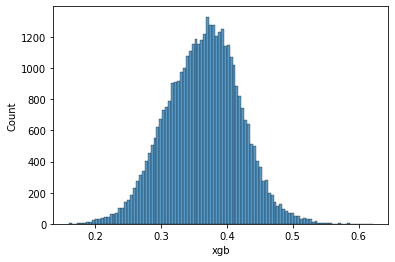

In [161]:
# X_5step_blend.xgb.hist()
sns.histplot(X_5step_blend.xgb)

In [162]:
rf_blend = RandomForestClassifier(**rf_params, random_state=123)
scores = cross_val_score(
    rf_blend, X_5step_blend.to_numpy(), y, cv=kfolds,
    scoring="roc_auc"
)

scores.mean()

0.8353595816870163

In [168]:
x_train, x_valid, y_train, y_valid = train_test_split(X_5step_blend,y, test_size = 0.25, random_state = 123, stratify=y)
rf_blend = RandomForestClassifier(**rf_params, random_state=123)
rf_blend.fit(x_train, y_train)

preds_train = rf_blend.predict_proba(x_train)[:,1]
preds_valid = rf_blend.predict_proba(x_valid)[:,1]
auc_train = roc_auc_score(y_train, preds_train)
auc_valid = roc_auc_score(y_valid, preds_valid)

print(f"train: {auc_train:.5f} | valid: {auc_valid:.5f} |")

train: 0.89095 | test: 0.83914 |


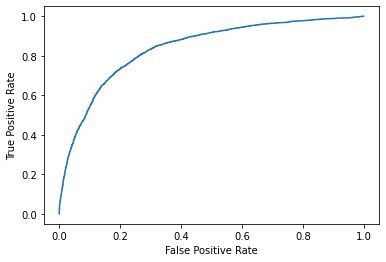

In [171]:
#define metrics
y_pred_proba = rf_blend.predict_proba(x_valid)[:,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

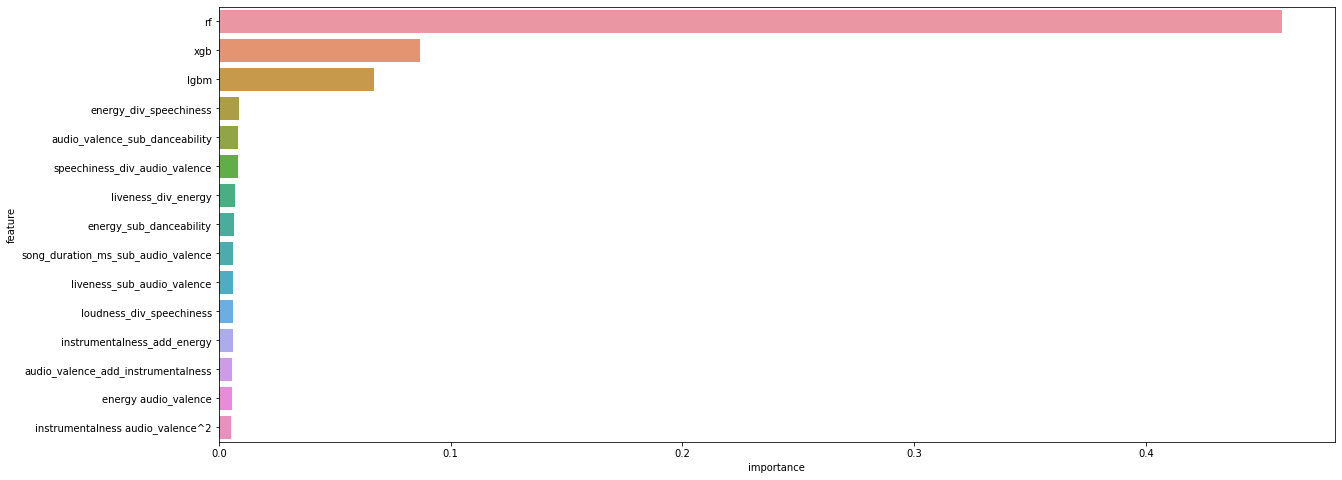

In [175]:
d = pd.DataFrame(np.array([x_train.columns,list(rf_blend.feature_importances_)]).T, columns=['feature','importance'])
d["importance"] = pd.to_numeric(d["importance"])
d = d.sort_values('importance', ascending=False)
plt.figure(figsize=(20,8))
sns.barplot(y="feature", x="importance", data=d.iloc[:15])
plt.show()

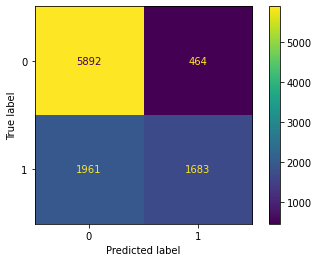

In [178]:
plot_confusion_matrix(rf_blend, x_valid, y_valid)  
plt.show()